# KAMA-MSR Model Comparison and Analysis

This notebook loads multiple KAMA-MSR models, compares their characteristics, and identifies potential areas for improvement.

## 1. Import Required Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import skew, kurtosis
import pickle
import os
from typing import Dict, List, Tuple
from datetime import datetime
import warnings

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load All Models from Directory

In [65]:
def load_all_models(sub_folder: str, edte_sub_folder: str, n_regimes: int = 2) -> Dict:
    """
    Load all KAMA-MSR models from a specified directory.
    
    Parameters:
    -----------
    sub_folder : str
        Asset type subfolder (e.g., 'us_equity', 'international_index')
    edte_sub_folder : str
        End date subfolder (e.g., '20220101')
    n_regimes : int
        Number of MSR regimes (used to construct filename)
    
    Returns:
    --------
    Dict : Dictionary with asset names as keys and loaded models as values
    """
    models = {}
    model_dir = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}'
    
    if not os.path.exists(model_dir):
        print(f"❌ Directory not found: {model_dir}")
        return models
    
    print(f"Loading models from: {model_dir}\n")
    
    # Get all pickle files
    pkl_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl') and f != 'metadata.pkl']
    
    for filename in pkl_files:
        filepath = os.path.join(model_dir, filename)
        
        try:
            with open(filepath, 'rb') as f:
                model = pickle.load(f)
            
            # Extract asset name from filename
            # Format: AssetName_KAMA-MSR_X-regimes.pkl
            asset_name = filename.replace('_KAMA-MSR_', '|||').split('|||')[0]
            asset_name = asset_name.replace('_', ' ')
            
            models[asset_name] = model
            # print(f"✓ Loaded: {asset_name}")
            
        except Exception as e:
            print(f"❌ Error loading {filename}: {str(e)}")
    
    print(f"\n{'='*80}")
    print(f"Successfully loaded {len(models)} models")
    print(f"{'='*80}\n")
    
    return models

def get_available_model_folders() -> pd.DataFrame:
    """
    Scan the saved_models directory to show available model configurations.
    
    Returns:
    --------
    pd.DataFrame : Summary of available model folders
    """
    base_dir = 'saved_models/KAMA_MSR'
    
    if not os.path.exists(base_dir):
        print(f"❌ Base directory not found: {base_dir}")
        return pd.DataFrame()
    
    folders = []
    
    for asset_type in os.listdir(base_dir):
        asset_type_path = os.path.join(base_dir, asset_type)
        
        if not os.path.isdir(asset_type_path):
            continue
            
        for date_folder in os.listdir(asset_type_path):
            date_folder_path = os.path.join(asset_type_path, date_folder)
            
            if not os.path.isdir(date_folder_path):
                continue
            
            # Count models
            pkl_files = [f for f in os.listdir(date_folder_path) 
                        if f.endswith('.pkl') and f != 'metadata.pkl']
            
            if pkl_files:
                folders.append({
                    'Asset Type': asset_type,
                    'End Date': date_folder,
                    'N Models': len(pkl_files),
                    'Path': f"{asset_type}/{date_folder}"
                })
    
    df = pd.DataFrame(folders)
    return df.sort_values(['Asset Type', 'End Date']) if not df.empty else df

In [66]:
# Display available model configurations
available_models = get_available_model_folders()
print("Available Model Configurations:")
print("="*80)
if not available_models.empty:
    display(available_models)
else:
    print("No models found!")

Available Model Configurations:


,Asset Type,End Date,N Models,Path
1,commodity,20190101,12,commodity/20190101
2,commodity,20220101,12,commodity/20220101
4,us_bond,20220101,3,us_bond/20220101
0,us_equity,20220101,26,us_equity/20220101
3,us_traded_international_equity_etfs,20220101,8,us_traded_international_equity_etfs/20220101


In [67]:
# Load models - ADJUST THESE PARAMETERS
# sub_folder = 'us_equity'  # Change to your asset type
edte_sub_folder = '20220101'  # Change to your date
n_regimes = 2

models_us_equity = load_all_models('us_equity', edte_sub_folder, n_regimes)
models_commodity = load_all_models('commodity', edte_sub_folder, n_regimes)
models_int_equity = load_all_models('us_traded_international_equity_etfs', edte_sub_folder, n_regimes)

# remove indices from models - only use ETFs
models_us_equity = {k: v for k, v in models_us_equity.items() if k not in['S&P 500', 'Dow Jones Industrial Average', 'Nasdaq Composite', 'Nasdaq 100', 'Russell 2000']}

# if models:
#     print(f"\nLoaded models for assets:")
#     for i, asset_name in enumerate(models.keys(), 1):
#         print(f"  {i:2d}. {asset_name}")

models = {**models_us_equity, **models_commodity, **models_int_equity}

Loading models from: saved_models/KAMA_MSR/us_equity/20220101


Successfully loaded 26 models

Loading models from: saved_models/KAMA_MSR/commodity/20220101


Successfully loaded 12 models

Loading models from: saved_models/KAMA_MSR/us_traded_international_equity_etfs/20220101


Successfully loaded 8 models



## 3. Extract Model Metadata and Parameters

In [68]:
def extract_model_metadata(models: Dict) -> pd.DataFrame:
    """
    Extract comprehensive metadata from all loaded models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Comprehensive metadata for all models
    """
    metadata = []
    
    for asset_name, model in models.items():
        try:
            # Basic info
            n_data_points = len(model.prices) if model.prices is not None else 0
            n_regimes_msr = model.msr.n_regimes
            n_combined_regimes = model.n_combined_regimes
            
            # KAMA parameters
            kama_n = model.kama.n
            kama_n_fast = model.kama.n_fast
            kama_n_slow = model.kama.n_slow
            gamma = model.gamma
            
            # Regime labels
            regime_labels = model.regime_labels.dropna()
            n_regime_changes = (regime_labels.diff() != 0).sum()
            
            # Regime distribution
            regime_counts = regime_labels.value_counts()
            regime_pcts = regime_counts / len(regime_labels) * 100
            
            # MSR parameters
            msr_means = model.msr.means
            msr_stds = model.msr.stds
            msr_betas = model.msr.betas
            
            # Build metadata dict
            meta = {
                'Asset': asset_name,
                'N_Data_Points': n_data_points,
                'N_MSR_Regimes': n_regimes_msr,
                'N_Combined_Regimes': n_combined_regimes,
                'KAMA_n': kama_n,
                'KAMA_n_fast': kama_n_fast,
                'KAMA_n_slow': kama_n_slow,
                'Filter_gamma': gamma,
                'N_Regime_Changes': n_regime_changes,
                'Avg_Regime_Duration': len(regime_labels) / (n_regime_changes + 1),
            }
            
            # Add regime-specific data
            for i in range(n_combined_regimes):
                meta[f'Regime_{i}_Pct'] = regime_pcts.get(i, 0)
                meta[f'Regime_{i}_Count'] = regime_counts.get(i, 0)
            
            # Add MSR parameters
            for i in range(n_regimes_msr):
                meta[f'MSR_Mean_{i}'] = msr_means[i]
                meta[f'MSR_Std_{i}'] = msr_stds[i]
                meta[f'MSR_Beta_{i}'] = msr_betas[i]
            
            # Add transition probabilities
            for i in range(n_regimes_msr):
                for j in range(n_regimes_msr):
                    meta[f'Trans_P_{i}_to_{j}'] = model.msr.transition_probs[i, j]
            
            metadata.append(meta)
            
        except Exception as e:
            print(f"❌ Error extracting metadata for {asset_name}: {str(e)}")
    
    df = pd.DataFrame(metadata)
    return df

# Extract metadata
metadata_df = extract_model_metadata(models)

print("\nModel Metadata Summary:")
print("="*80)
display(metadata_df.head())

print(f"\nShape: {metadata_df.shape}")
print(f"Columns: {list(metadata_df.columns)}")


Model Metadata Summary:


,Asset,N_Data_Points,N_MSR_Regimes,N_Combined_Regimes,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma,N_Regime_Changes,Avg_Regime_Duration,Regime_0_Pct,Regime_0_Count,Regime_1_Pct,Regime_1_Count,Regime_2_Pct,Regime_2_Count,Regime_3_Pct,Regime_3_Count,MSR_Mean_0,MSR_Std_0,MSR_Beta_0,MSR_Mean_1,MSR_Std_1,MSR_Beta_1,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1
0,Consumer Discretionary Select Sector SPDR,5795,2,4,16,10,50,0.5,114,50.2435,74.1260,4283,17.5320,1013,1.0557,61,7.2863,421,0.0005,0.0125,-0.0062,-0.0012,0.0370,-0.0170,0.9931,0.0069,0.0693,0.9307
1,Consumer Staples Select Sector SPDR,5795,2,4,9,10,60,0.5,134,42.8519,71.9965,4165,25.7736,1491,0.1729,10,2.0570,119,0.0002,0.0103,-0.0196,-0.0018,0.0492,-0.0189,0.9951,0.0049,0.1785,0.8215
2,iShares Micro-Cap ETF,4124,2,4,8,2,40,2.0,255,16.0742,54.8481,2257,36.5735,1505,3.4022,140,5.1762,213,0.0005,0.0140,-0.0038,-0.0027,0.0436,-0.0531,0.9954,0.0046,0.0491,0.9509
3,Invesco S&P 500 Equal Weight ETF,4703,2,4,10,10,50,1.0,70,66.0845,79.5183,3731,12.3615,580,0.9591,45,7.1611,336,0.0006,0.0114,-0.0053,-0.0018,0.0401,-0.0391,0.9960,0.0040,0.0427,0.9573
4,iShares Russell 2000 ETF,5435,2,4,12,10,30,0.5,114,47.1478,66.1011,3584,25.8576,1402,0.5533,30,7.4880,406,0.0005,0.0135,-0.0142,-0.0020,0.0408,-0.0494,0.9958,0.0042,0.0473,0.9527



Shape: (41, 28)
Columns: ['Asset', 'N_Data_Points', 'N_MSR_Regimes', 'N_Combined_Regimes', 'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma', 'N_Regime_Changes', 'Avg_Regime_Duration', 'Regime_0_Pct', 'Regime_0_Count', 'Regime_1_Pct', 'Regime_1_Count', 'Regime_2_Pct', 'Regime_2_Count', 'Regime_3_Pct', 'Regime_3_Count', 'MSR_Mean_0', 'MSR_Std_0', 'MSR_Beta_0', 'MSR_Mean_1', 'MSR_Std_1', 'MSR_Beta_1', 'Trans_P_0_to_0', 'Trans_P_0_to_1', 'Trans_P_1_to_0', 'Trans_P_1_to_1']


## 4. Compare KAMA Parameters Across Assets

In [69]:
# Summary statistics for KAMA parameters
kama_cols = ['KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma']
kama_summary = metadata_df[['Asset'] + kama_cols].describe()

print("KAMA Parameter Summary Statistics:")
print("="*80)
display(kama_summary)

# Identify unique parameter combinations
unique_kama = metadata_df[kama_cols].drop_duplicates()
print(f"\nNumber of unique KAMA parameter combinations: {len(unique_kama)}")
print("\nUnique KAMA configurations:")
display(unique_kama)

KAMA Parameter Summary Statistics:


,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma
count,41.0000,41.0000,41.0000,41.0000
mean,18.4634,8.2683,44.2683,1.1829
std,9.4104,3.0168,14.8560,0.5890
min,5.0000,2.0000,20.0000,0.5000
25%,10.0000,9.0000,30.0000,0.5000
50%,17.0000,10.0000,50.0000,1.0000
75%,29.0000,10.0000,60.0000,1.7500
max,30.0000,10.0000,60.0000,2.0000



Number of unique KAMA parameter combinations: 38

Unique KAMA configurations:


,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma
0,16,10,50,0.50
1,9,10,60,0.50
2,8,2,40,2.00
3,10,10,50,1.00
4,12,10,30,0.50
5,30,10,50,2.00
6,7,9,55,1.00
7,30,10,60,1.50
8,5,10,55,1.00
9,17,9,35,2.00


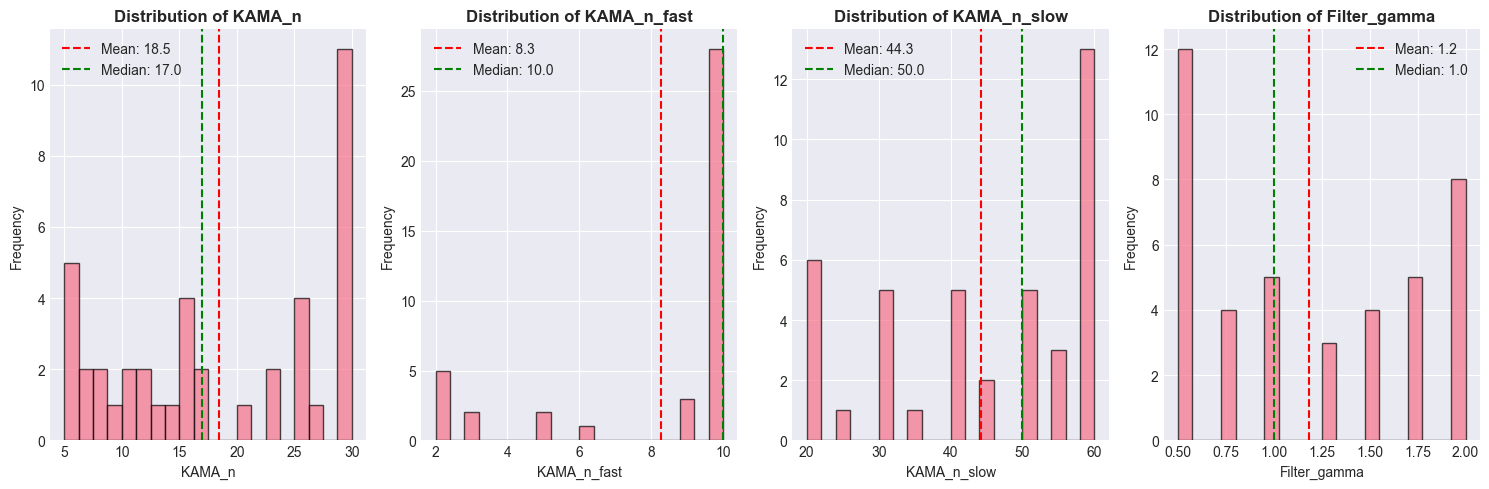

In [70]:
# Visualize KAMA parameters
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for idx, col in enumerate(kama_cols):
    ax = axes[idx]
    metadata_df[col].hist(bins=20, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.axvline(metadata_df[col].mean(), color='red', linestyle='--', 
               label=f'Mean: {metadata_df[col].mean():.1f}')
    ax.axvline(metadata_df[col].median(), color='green', linestyle='--', 
               label=f'Median: {metadata_df[col].median():.1f}')
    ax.legend()

plt.tight_layout()
plt.show()

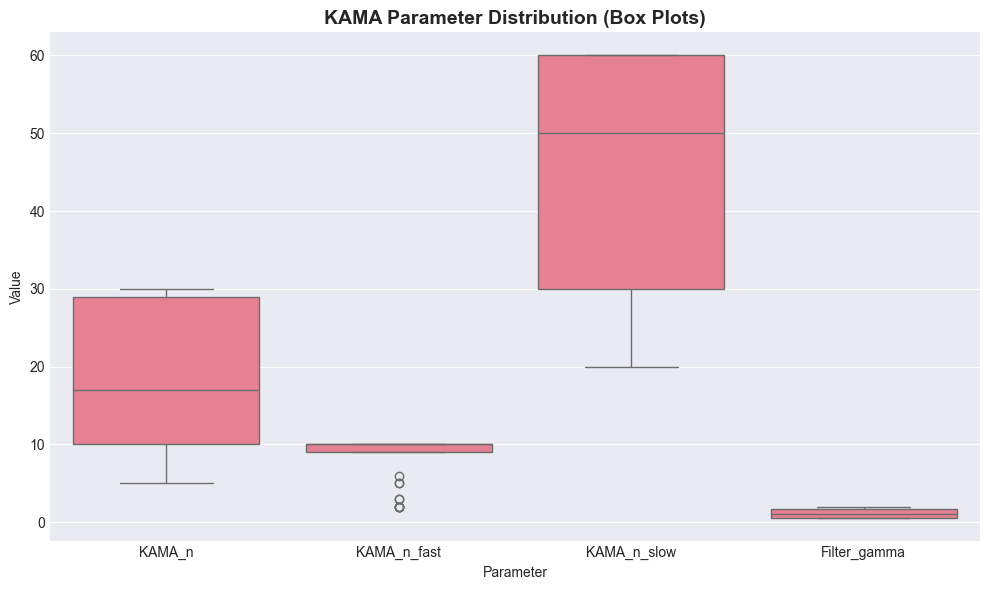


KAMA Parameter Outliers (values > 1.5 IQR):

KAMA_n_fast:
  iShares Micro-Cap ETF: 2
  Utilities Select Sector SPDR: 6
  Sugar: 3
  Wheat Futures: 5
  Live Cattle Futures: 3
  Natural Gas: 2
  Coffee: 2
  Corn Futures: 5
  Aluminum Futures: 2
  iShares China Large-Cap ETF: 2


In [71]:
# Box plots for KAMA parameters
fig, ax = plt.subplots(figsize=(10, 6))

kama_data = metadata_df[kama_cols].melt(var_name='Parameter', value_name='Value')
sns.boxplot(data=kama_data, x='Parameter', y='Value', ax=ax)
ax.set_title('KAMA Parameter Distribution (Box Plots)', fontsize=14, fontweight='bold')
ax.set_ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify outliers
print("\nKAMA Parameter Outliers (values > 1.5 IQR):")
print("="*80)
for col in kama_cols:
    Q1 = metadata_df[col].quantile(0.25)
    Q3 = metadata_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = metadata_df[(metadata_df[col] < Q1 - 1.5*IQR) | (metadata_df[col] > Q3 + 1.5*IQR)]
    if len(outliers) > 0:
        print(f"\n{col}:")
        for _, row in outliers.iterrows():
            print(f"  {row['Asset']}: {row[col]}")

## 5. Compare MSR Parameters Across Assets

In [72]:
# Extract MSR parameter columns
msr_mean_cols = [col for col in metadata_df.columns if col.startswith('MSR_Mean_')]
msr_std_cols = [col for col in metadata_df.columns if col.startswith('MSR_Std_')]
msr_beta_cols = [col for col in metadata_df.columns if col.startswith('MSR_Beta_')]

print("MSR Parameter Summary Statistics:")
print("="*80)

print("\nMSR Means:")
display(metadata_df[['Asset'] + msr_mean_cols].describe())

print("\nMSR Standard Deviations:")
display(metadata_df[['Asset'] + msr_std_cols].describe())

print("\nMSR Betas:")
display(metadata_df[['Asset'] + msr_beta_cols].describe())

MSR Parameter Summary Statistics:

MSR Means:


,MSR_Mean_0,MSR_Mean_1
count,41.0000,41.0000
mean,-0.0002,-0.0024
std,0.0035,0.0025
min,-0.0218,-0.0081
25%,0.0003,-0.0038
50%,0.0004,-0.0026
75%,0.0005,-0.0018
max,0.0009,0.0044



MSR Standard Deviations:


,MSR_Std_0,MSR_Std_1
count,41.0000,41.0000
mean,0.0185,0.0470
std,0.0308,0.0154
min,0.0100,0.0138
25%,0.0121,0.0382
50%,0.0132,0.0429
75%,0.0145,0.0503
max,0.2103,0.0912



MSR Betas:


,MSR_Beta_0,MSR_Beta_1
count,41.0000,41.0000
mean,-0.0116,-0.0568
std,0.0101,0.0874
min,-0.0292,-0.4784
25%,-0.0190,-0.0559
50%,-0.0130,-0.0469
75%,-0.0053,-0.0239
max,0.0178,0.0167


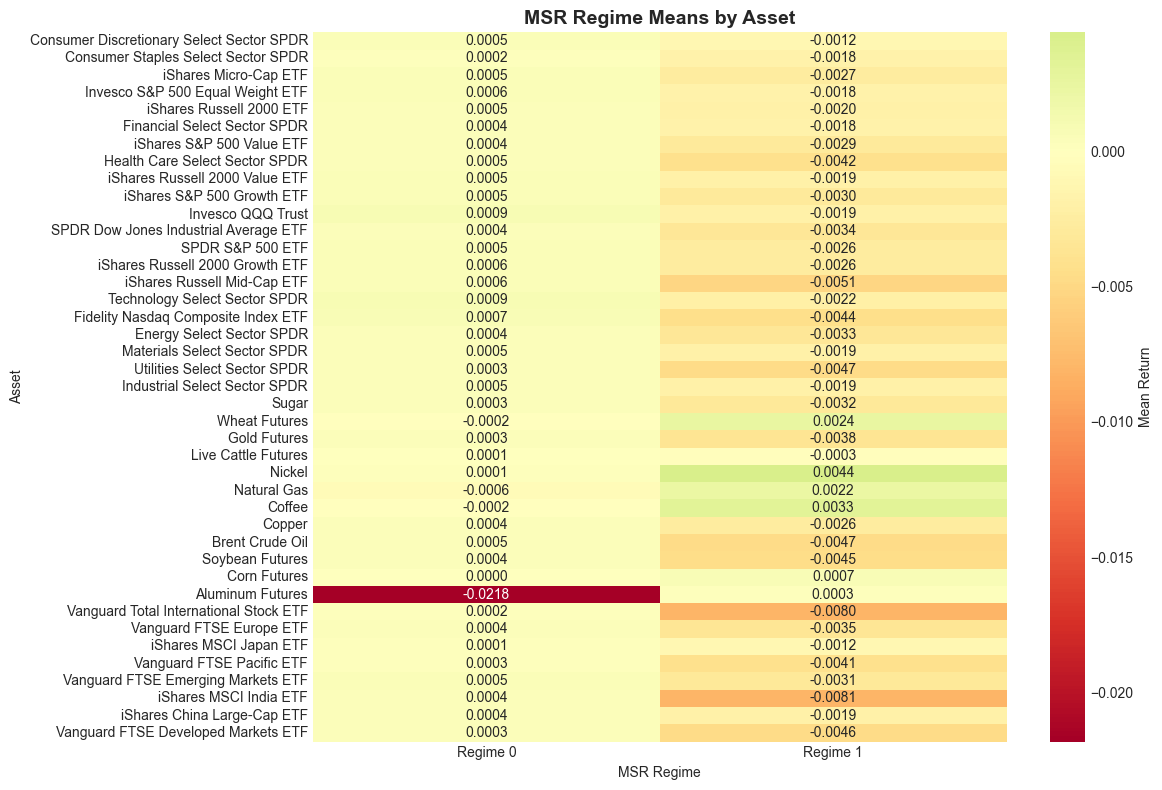

In [73]:
# Heatmap of MSR means
plt.figure(figsize=(12, 8))

msr_means_data = metadata_df[['Asset'] + msr_mean_cols].set_index('Asset')
msr_means_data.columns = [col.replace('MSR_Mean_', 'Regime ') for col in msr_means_data.columns]

sns.heatmap(msr_means_data, annot=True, fmt='.4f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Mean Return'})
plt.title('MSR Regime Means by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

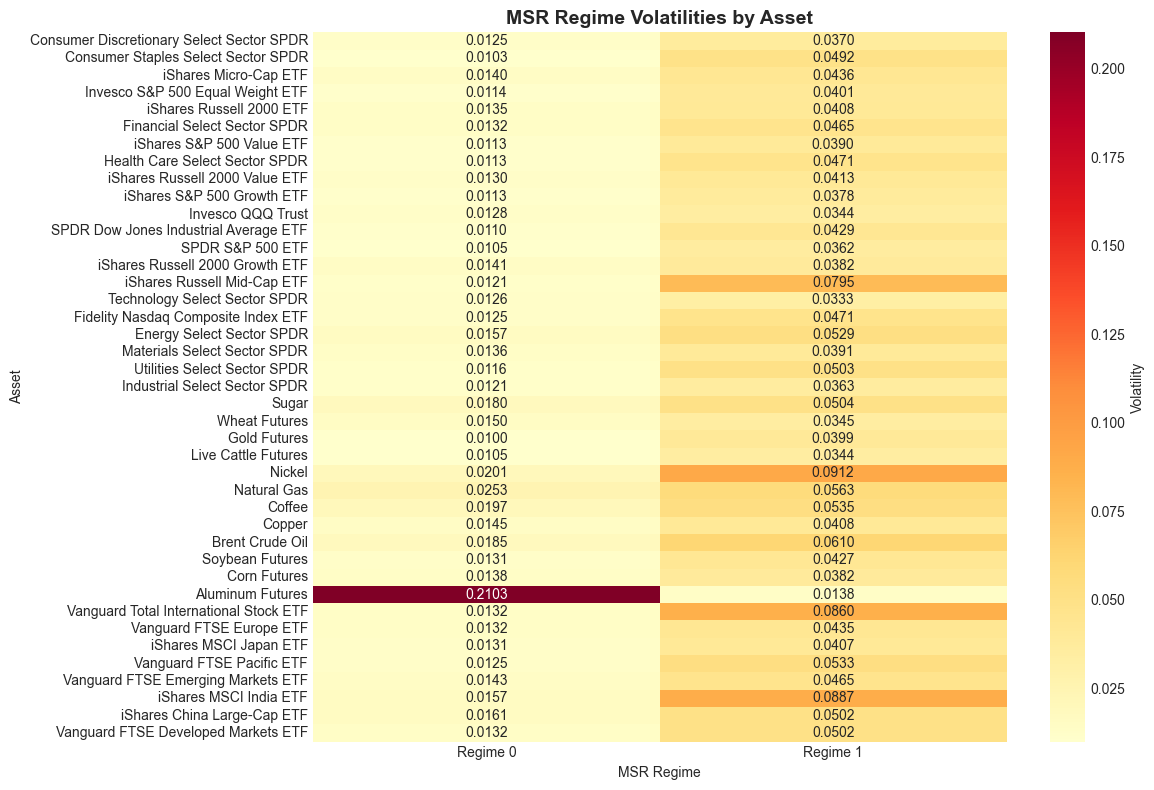

In [74]:
# Heatmap of MSR volatilities
plt.figure(figsize=(12, 8))

msr_stds_data = metadata_df[['Asset'] + msr_std_cols].set_index('Asset')
msr_stds_data.columns = [col.replace('MSR_Std_', 'Regime ') for col in msr_stds_data.columns]

sns.heatmap(msr_stds_data, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Volatility'})
plt.title('MSR Regime Volatilities by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

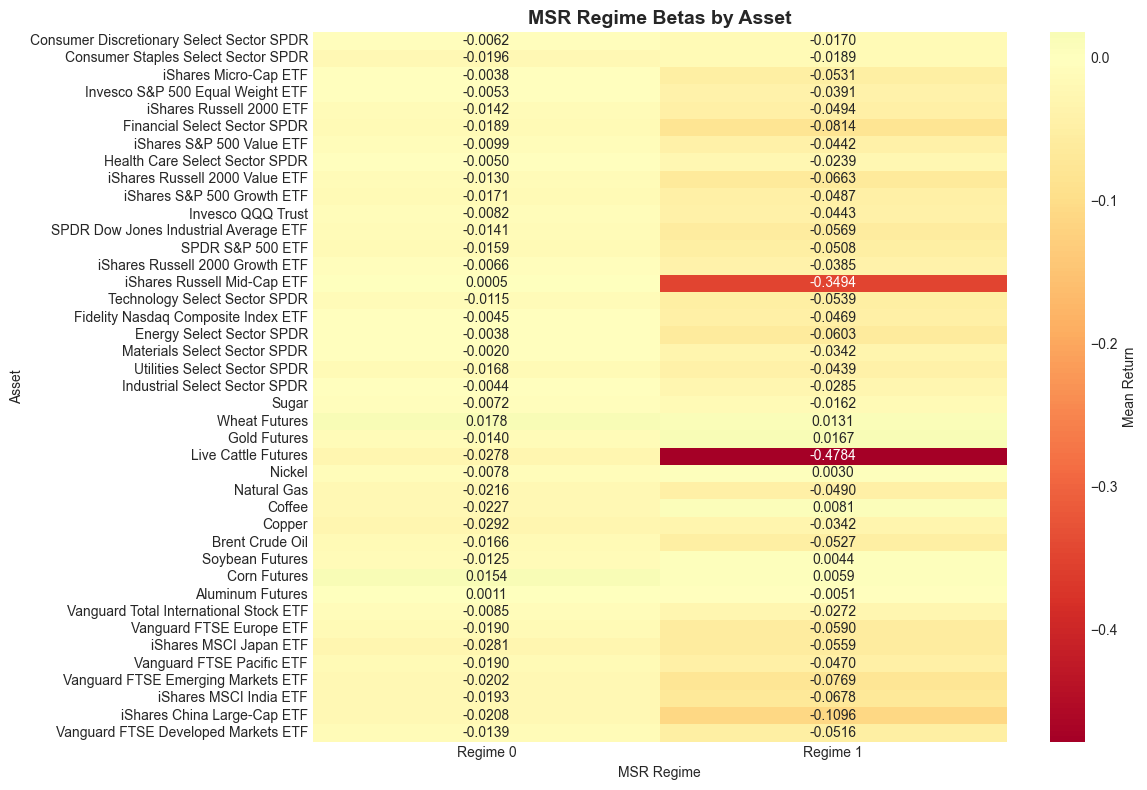

In [75]:
# Heatmap of MSR betas
plt.figure(figsize=(12, 8))

msr_betas_data = metadata_df[['Asset'] + msr_beta_cols].set_index('Asset')
msr_betas_data.columns = [col.replace('MSR_Beta_', 'Regime ') for col in msr_betas_data.columns]

sns.heatmap(msr_betas_data, annot=True, fmt='.4f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Mean Return'})
plt.title('MSR Regime Betas by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

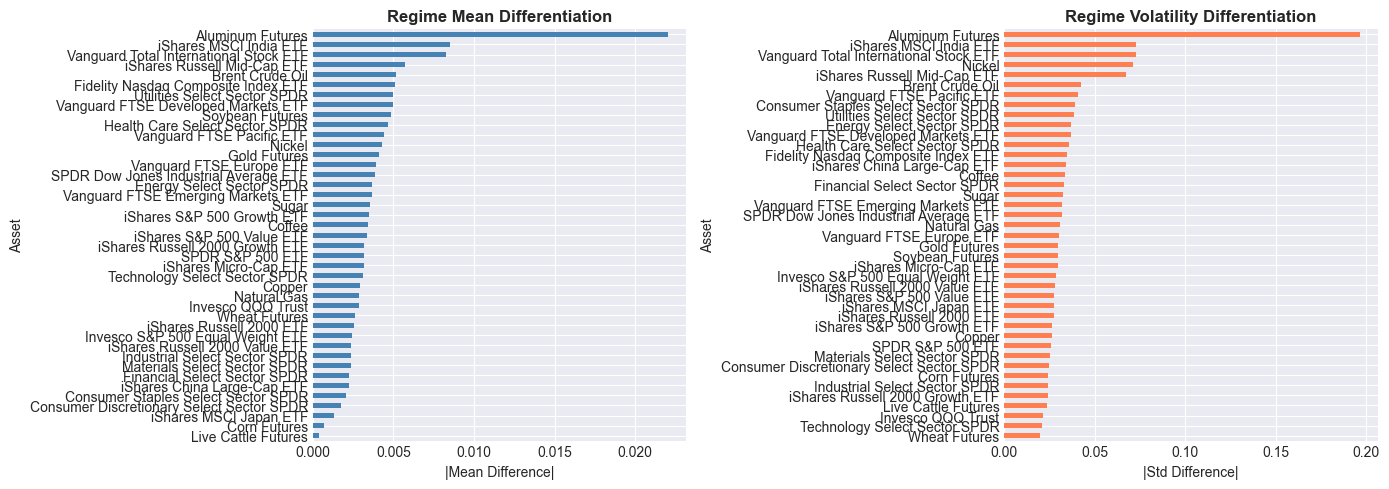


Assets with WEAK Regime Differentiation:

Lowest Mean Differentiation:


,Asset,Mean_Diff,MSR_Mean_0,MSR_Mean_1
24,Live Cattle Futures,0.0004,7.1872e-05,-0.0003
31,Corn Futures,0.0007,3.1116e-05,0.0007
35,iShares MSCI Japan ETF,0.0013,1.0450e-04,-0.0012
0,Consumer Discretionary Select Sector SPDR,0.0017,5.3038e-04,-0.0012
1,Consumer Staples Select Sector SPDR,0.0021,2.4981e-04,-0.0018



Lowest Volatility Differentiation:


,Asset,Std_Diff,MSR_Std_0,MSR_Std_1
22,Wheat Futures,0.0195,0.0150,0.0345
15,Technology Select Sector SPDR,0.0207,0.0126,0.0333
10,Invesco QQQ Trust,0.0217,0.0128,0.0344
24,Live Cattle Futures,0.0239,0.0105,0.0344
13,iShares Russell 2000 Growth ETF,0.0241,0.0141,0.0382


In [76]:
# Compare regime differentiation (difference between regimes)
if len(msr_mean_cols) == 2:
    metadata_df['Mean_Diff'] = abs(metadata_df['MSR_Mean_0'] - metadata_df['MSR_Mean_1'])
    metadata_df['Std_Diff'] = abs(metadata_df['MSR_Std_0'] - metadata_df['MSR_Std_1'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean difference
    metadata_df.sort_values('Mean_Diff').plot.barh(x='Asset', y='Mean_Diff', ax=axes[0], 
                                                     color='steelblue', legend=False)
    axes[0].set_title('Regime Mean Differentiation', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('|Mean Difference|')
    
    # Std difference
    metadata_df.sort_values('Std_Diff').plot.barh(x='Asset', y='Std_Diff', ax=axes[1], 
                                                    color='coral', legend=False)
    axes[1].set_title('Regime Volatility Differentiation', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('|Std Difference|')
    
    plt.tight_layout()
    plt.show()
    
    print("\nAssets with WEAK Regime Differentiation:")
    print("="*80)
    print("\nLowest Mean Differentiation:")
    display(metadata_df.nsmallest(5, 'Mean_Diff')[['Asset', 'Mean_Diff', 'MSR_Mean_0', 'MSR_Mean_1']])
    
    print("\nLowest Volatility Differentiation:")
    display(metadata_df.nsmallest(5, 'Std_Diff')[['Asset', 'Std_Diff', 'MSR_Std_0', 'MSR_Std_1']])

## 6. Regime Distribution Analysis

In [77]:
# Regime distribution summary
regime_pct_cols = [col for col in metadata_df.columns if col.startswith('Regime_') and col.endswith('_Pct')]

print("Regime Distribution Summary:")
print("="*80)
display(metadata_df[['Asset'] + regime_pct_cols].describe())

# Identify imbalanced regimes
print("\nAssets with Imbalanced Regime Distributions:")
print("="*80)

for _, row in metadata_df.iterrows():
    pcts = [row[col] for col in regime_pct_cols]
    max_pct = max(pcts)
    min_pct = min(pcts)
    
    if max_pct > 70:  # One regime dominates
        print(f"\n{row['Asset']}:")
        for i, col in enumerate(regime_pct_cols):
            print(f"  Regime {i}: {row[col]:.1f}%")

Regime Distribution Summary:


,Regime_0_Pct,Regime_1_Pct,Regime_2_Pct,Regime_3_Pct
count,41.0000,41.0000,41.0000,41.0000
mean,57.8711,32.2679,3.6688,6.1922
std,17.3177,15.4280,11.8624,4.1172
min,0.1031,0.0000,0.0403,1.0620
25%,45.4815,20.2117,0.5031,3.3457
50%,62.5195,33.3728,0.9494,5.5999
75%,71.9965,42.2559,2.3496,7.7110
max,79.5183,71.7445,76.4433,23.4536



Assets with Imbalanced Regime Distributions:

Consumer Discretionary Select Sector SPDR:
  Regime 0: 74.1%
  Regime 1: 17.5%
  Regime 2: 1.1%
  Regime 3: 7.3%

Consumer Staples Select Sector SPDR:
  Regime 0: 72.0%
  Regime 1: 25.8%
  Regime 2: 0.2%
  Regime 3: 2.1%

Invesco S&P 500 Equal Weight ETF:
  Regime 0: 79.5%
  Regime 1: 12.4%
  Regime 2: 1.0%
  Regime 3: 7.2%

Health Care Select Sector SPDR:
  Regime 0: 76.8%
  Regime 1: 20.2%
  Regime 2: 0.7%
  Regime 3: 2.3%

iShares S&P 500 Growth ETF:
  Regime 0: 70.7%
  Regime 1: 22.6%
  Regime 2: 0.7%
  Regime 3: 6.0%

SPDR Dow Jones Industrial Average ETF:
  Regime 0: 76.4%
  Regime 1: 18.6%
  Regime 2: 0.4%
  Regime 3: 4.6%

SPDR S&P 500 ETF:
  Regime 0: 76.5%
  Regime 1: 17.0%
  Regime 2: 0.9%
  Regime 3: 5.6%

iShares Russell 2000 Growth ETF:
  Regime 0: 72.2%
  Regime 1: 17.9%
  Regime 2: 1.7%
  Regime 3: 8.2%

iShares Russell Mid-Cap ETF:
  Regime 0: 74.4%
  Regime 1: 21.6%
  Regime 2: 0.2%
  Regime 3: 3.8%

Fidelity Nasdaq Compo

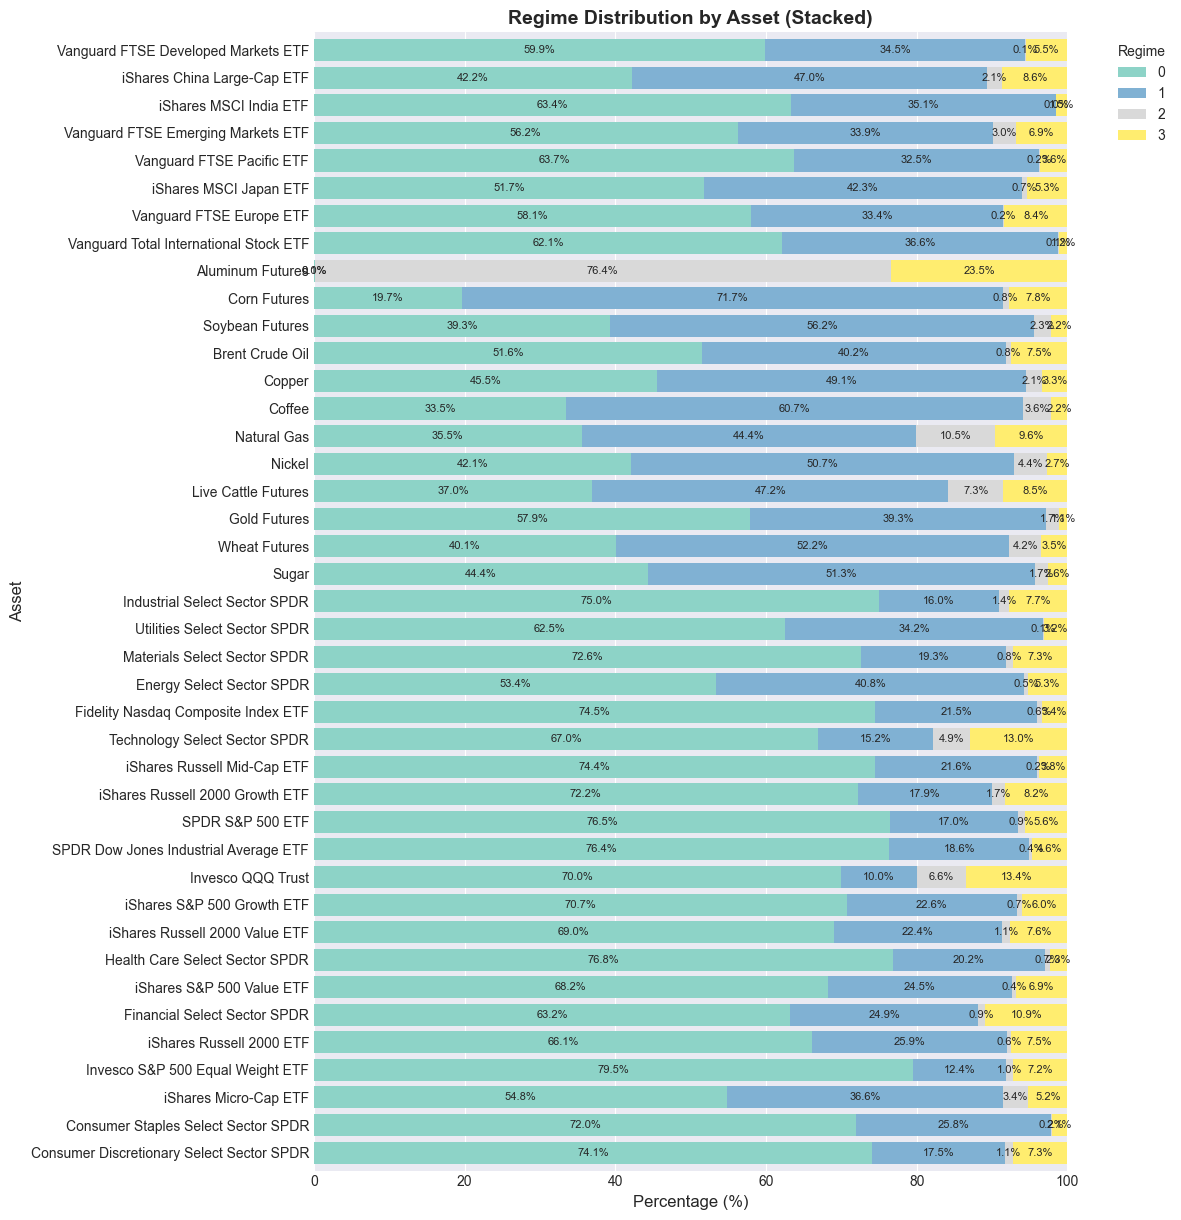

In [78]:
# Stacked bar chart of regime distributions
regime_pct_data = metadata_df[['Asset'] + regime_pct_cols].set_index('Asset')
regime_pct_data.columns = [col.replace('Regime_', '').replace('_Pct', '') for col in regime_pct_data.columns]

ax = regime_pct_data.plot.barh(stacked=True, figsize=(12, max(8, len(models)*0.3)), 
                                colormap='Set3', width=0.8)
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('Asset', fontsize=12)
ax.set_title('Regime Distribution by Asset (Stacked)', fontsize=14, fontweight='bold')
ax.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, 100)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8)

plt.tight_layout()
plt.show()

Regime Diversity Scores:
(0 = Perfectly balanced, 1 = Completely concentrated)



,Asset,Regime_Diversity_Score,Regime_0_Pct,Regime_1_Pct,Regime_2_Pct,Regime_3_Pct
32,Aluminum Futures,0.6014,0.1031,0.0000,76.4433,23.4536
7,Health Care Select Sector SPDR,0.5337,76.8043,20.2117,0.6593,2.3248
3,Invesco S&P 500 Equal Weight ETF,0.5138,79.5183,12.3615,0.9591,7.1611
1,Consumer Staples Select Sector SPDR,0.5117,71.9965,25.7736,0.1729,2.0570
11,SPDR Dow Jones Industrial Average ETF,0.5070,76.3579,18.5938,0.3999,4.6485
14,iShares Russell Mid-Cap ETF,0.5036,74.4436,21.5541,0.2343,3.7681
16,Fidelity Nasdaq Composite Index ETF,0.4986,74.5016,21.5115,0.5915,3.3954
12,SPDR S&P 500 ETF,0.4865,76.4722,16.9785,0.9494,5.5999
38,iShares MSCI India ETF,0.4779,63.3615,35.0665,0.0403,1.5316
33,Vanguard Total International Stock ETF,0.4770,62.1129,36.5756,0.1457,1.1658


<Figure size 1000x1230 with 0 Axes>

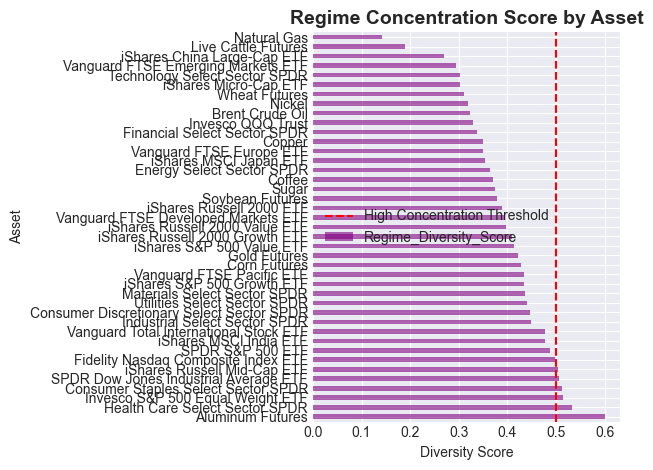

In [79]:
# Regime diversity metric (entropy-based)
from scipy.stats import entropy

def regime_diversity_score(pcts):
    """Calculate normalized entropy as diversity score (0=uniform, 1=concentrated)"""
    pcts_normalized = np.array(pcts) / 100.0
    max_entropy = np.log(len(pcts))
    return 1 - (entropy(pcts_normalized) / max_entropy) if max_entropy > 0 else 0

metadata_df['Regime_Diversity_Score'] = metadata_df.apply(
    lambda row: regime_diversity_score([row[col] for col in regime_pct_cols]), axis=1
)

print("Regime Diversity Scores:")
print("="*80)
print("(0 = Perfectly balanced, 1 = Completely concentrated)\n")

diversity_sorted = metadata_df[['Asset', 'Regime_Diversity_Score'] + regime_pct_cols].sort_values('Regime_Diversity_Score', ascending=False)
display(diversity_sorted)

# Visualize
plt.figure(figsize=(10, max(6, len(models)*0.3)))
diversity_sorted.plot.barh(x='Asset', y='Regime_Diversity_Score', 
                           color='purple', alpha=0.6, legend=False)
plt.axvline(0.5, color='red', linestyle='--', label='High Concentration Threshold')
plt.xlabel('Diversity Score')
plt.ylabel('Asset')
plt.title('Regime Concentration Score by Asset', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Regime Duration Analysis

In [80]:
def extract_regime_duration_stats(models: Dict) -> pd.DataFrame:
    """
    Extract regime duration statistics from all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Regime duration statistics for all models
    """
    duration_stats = []
    
    for asset_name, model in models.items():
        try:
            regime_labels = model.regime_labels.dropna()
            
            # Calculate regime durations
            regime_changes = regime_labels != regime_labels.shift(1)
            regime_blocks = regime_changes.cumsum()
            
            durations = regime_labels.groupby(regime_blocks).size()
            
            stats = {
                'Asset': asset_name,
                'Mean_Duration': durations.mean(),
                'Median_Duration': durations.median(),
                'Std_Duration': durations.std(),
                'Min_Duration': durations.min(),
                'Max_Duration': durations.max(),
                'Q25_Duration': durations.quantile(0.25),
                'Q75_Duration': durations.quantile(0.75),
                'N_Regimes': len(durations),
                'Pct_Single_Period': (durations == 1).sum() / len(durations) * 100
            }
            
            duration_stats.append(stats)
            
        except Exception as e:
            print(f"❌ Error extracting duration stats for {asset_name}: {str(e)}")
    
    return pd.DataFrame(duration_stats)

duration_df = extract_regime_duration_stats(models)

print("Regime Duration Statistics:")
print("="*80)
display(duration_df.sort_values('Mean_Duration', ascending=False))

Regime Duration Statistics:


,Asset,Mean_Duration,Median_Duration,Std_Duration,Min_Duration,Max_Duration,Q25_Duration,Q75_Duration,N_Regimes,Pct_Single_Period
13,iShares Russell 2000 Growth ETF,94.0351,29.0,185.5485,1,961,12.00,87.00,57,1.7544
11,SPDR Dow Jones Industrial Average ETF,82.2055,26.0,152.0491,1,955,6.00,76.00,73,4.1096
25,Nickel,78.5682,27.0,126.5204,1,621,8.00,75.25,44,6.8182
12,SPDR S&P 500 ETF,78.1398,18.0,156.0300,1,822,8.00,47.00,93,3.2258
17,Energy Select Sector SPDR,77.8784,22.0,141.4391,1,981,5.25,89.00,74,5.4054
14,iShares Russell Mid-Cap ETF,77.5909,26.0,119.2696,1,481,6.00,82.00,66,9.0909
20,Industrial Select Sector SPDR,74.9351,23.0,145.9268,1,786,7.00,57.00,77,2.5974
16,Fidelity Nasdaq Composite Index ETF,72.4444,27.0,123.8657,1,671,11.00,79.00,63,1.5873
10,Invesco QQQ Trust,71.4500,21.0,118.8810,1,691,6.00,85.00,80,7.5000
7,Health Care Select Sector SPDR,71.1481,18.0,137.0930,1,960,5.00,53.00,81,14.8148


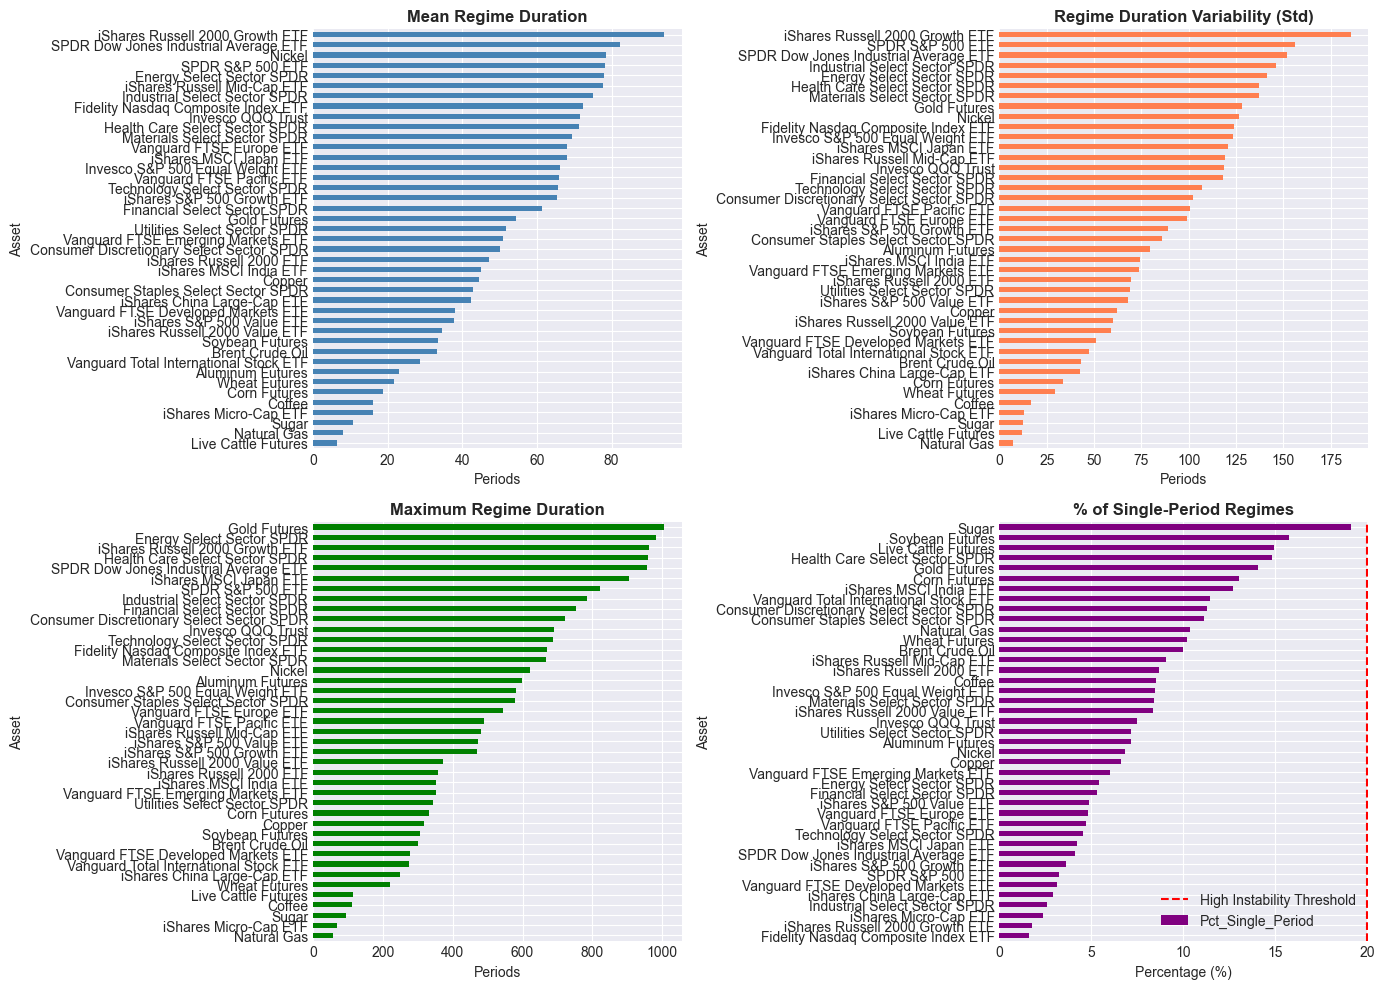

In [81]:
# Visualize regime duration characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean duration
duration_df.sort_values('Mean_Duration').plot.barh(x='Asset', y='Mean_Duration', 
                                                     ax=axes[0,0], color='steelblue', legend=False)
axes[0,0].set_title('Mean Regime Duration', fontweight='bold')
axes[0,0].set_xlabel('Periods')

# Duration variability (std)
duration_df.sort_values('Std_Duration').plot.barh(x='Asset', y='Std_Duration', 
                                                    ax=axes[0,1], color='coral', legend=False)
axes[0,1].set_title('Regime Duration Variability (Std)', fontweight='bold')
axes[0,1].set_xlabel('Periods')

# Max duration
duration_df.sort_values('Max_Duration').plot.barh(x='Asset', y='Max_Duration', 
                                                    ax=axes[1,0], color='green', legend=False)
axes[1,0].set_title('Maximum Regime Duration', fontweight='bold')
axes[1,0].set_xlabel('Periods')

# Percentage of single-period regimes
duration_df.sort_values('Pct_Single_Period').plot.barh(x='Asset', y='Pct_Single_Period', 
                                                         ax=axes[1,1], color='purple', legend=False)
axes[1,1].set_title('% of Single-Period Regimes', fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')
axes[1,1].axvline(20, color='red', linestyle='--', label='High Instability Threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [82]:
# Identify problematic duration patterns
print("Assets with Regime Duration Issues:")
print("="*80)

print("\n1. HIGH REGIME INSTABILITY (>20% single-period regimes):")
unstable = duration_df[duration_df['Pct_Single_Period'] > 20].sort_values('Pct_Single_Period', ascending=False)
if len(unstable) > 0:
    display(unstable[['Asset', 'Pct_Single_Period', 'Mean_Duration', 'N_Regimes']])
else:
    print("  ✓ None found")

print("\n2. VERY SHORT AVERAGE DURATIONS (<5 periods):")
short_duration = duration_df[duration_df['Mean_Duration'] < 5].sort_values('Mean_Duration')
if len(short_duration) > 0:
    display(short_duration[['Asset', 'Mean_Duration', 'Median_Duration', 'Pct_Single_Period']])
else:
    print("  ✓ None found")

print("\n3. VERY LONG AVERAGE DURATIONS (>50 periods):")
long_duration = duration_df[duration_df['Mean_Duration'] > 50].sort_values('Mean_Duration', ascending=False)
if len(long_duration) > 0:
    display(long_duration[['Asset', 'Mean_Duration', 'Max_Duration', 'N_Regimes']])
else:
    print("  ✓ None found")

Assets with Regime Duration Issues:

1. HIGH REGIME INSTABILITY (>20% single-period regimes):
  ✓ None found

2. VERY SHORT AVERAGE DURATIONS (<5 periods):
  ✓ None found

3. VERY LONG AVERAGE DURATIONS (>50 periods):


,Asset,Mean_Duration,Max_Duration,N_Regimes
13,iShares Russell 2000 Growth ETF,94.0351,961,57
11,SPDR Dow Jones Industrial Average ETF,82.2055,955,73
25,Nickel,78.5682,621,44
12,SPDR S&P 500 ETF,78.1398,822,93
17,Energy Select Sector SPDR,77.8784,981,74
14,iShares Russell Mid-Cap ETF,77.5909,481,66
20,Industrial Select Sector SPDR,74.9351,786,77
16,Fidelity Nasdaq Composite Index ETF,72.4444,671,63
10,Invesco QQQ Trust,71.4500,691,80
7,Health Care Select Sector SPDR,71.1481,960,81


## 8. Transition Probability Comparison

In [83]:
# Extract transition probability columns
trans_prob_cols = [col for col in metadata_df.columns if col.startswith('Trans_P_')]

print("Transition Probability Summary:")
print("="*80)
display(metadata_df[['Asset'] + trans_prob_cols].describe())

# Calculate average transition probabilities
print("\n\nAverage Transition Probabilities Across All Assets:")
avg_trans_probs = metadata_df[trans_prob_cols].mean()
for col in trans_prob_cols:
    from_regime = col.split('_')[2]
    to_regime = col.split('_')[4]
    print(f"  P({from_regime} → {to_regime}): {avg_trans_probs[col]:.4f}")

Transition Probability Summary:


,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1
count,41.0000,41.0000,41.0000,41.0000
mean,0.9751,0.0249,0.1197,0.8803
std,0.0874,0.0874,0.0962,0.0962
min,0.4402,0.0040,0.0055,0.5866
25%,0.9903,0.0051,0.0574,0.8487
50%,0.9937,0.0063,0.0865,0.9135
75%,0.9949,0.0097,0.1513,0.9426
max,0.9960,0.5598,0.4134,0.9945




Average Transition Probabilities Across All Assets:
  P(0 → 0): 0.9751
  P(0 → 1): 0.0249
  P(1 → 0): 0.1197
  P(1 → 1): 0.8803


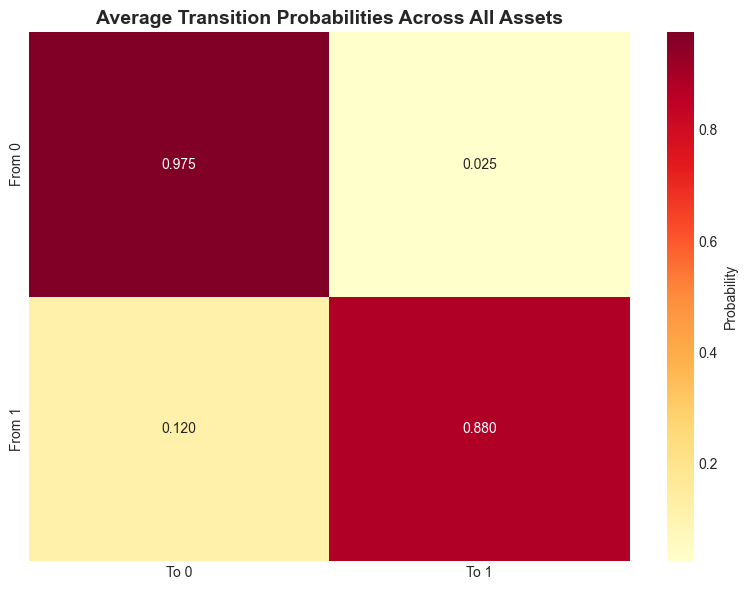

In [84]:
# Heatmap of average transition probabilities
n_msr_regimes = models[list(models.keys())[0]].msr.n_regimes

avg_trans_matrix = np.zeros((n_msr_regimes, n_msr_regimes))

for i in range(n_msr_regimes):
    for j in range(n_msr_regimes):
        col_name = f'Trans_P_{i}_to_{j}'
        avg_trans_matrix[i, j] = metadata_df[col_name].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(avg_trans_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=[f'To {i}' for i in range(n_msr_regimes)],
            yticklabels=[f'From {i}' for i in range(n_msr_regimes)],
            cbar_kws={'label': 'Probability'})
plt.title('Average Transition Probabilities Across All Assets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [85]:
# Identify assets with unusual transition probabilities
print("Assets with Unusual Transition Probabilities:")
print("="*80)

# Calculate persistence (diagonal probabilities)
for i in range(n_msr_regimes):
    col_name = f'Trans_P_{i}_to_{i}'
    metadata_df[f'Persistence_{i}'] = metadata_df[col_name]

persistence_cols = [f'Persistence_{i}' for i in range(n_msr_regimes)]

print("\nPersistence Probabilities (P(stay in same regime)):")
display(metadata_df[['Asset'] + persistence_cols].sort_values(persistence_cols[0]))

# Very low persistence (< 0.8)
print("\n\nAssets with LOW PERSISTENCE (<0.8):")
for i, col in enumerate(persistence_cols):
    low_persist = metadata_df[metadata_df[col] < 0.8][['Asset', col]]
    if len(low_persist) > 0:
        print(f"\nRegime {i}:")
        display(low_persist.sort_values(col))

Assets with Unusual Transition Probabilities:

Persistence Probabilities (P(stay in same regime)):


,Asset,Persistence_0,Persistence_1
32,Aluminum Futures,0.4402,0.9945
24,Live Cattle Futures,0.8874,0.6137
21,Sugar,0.9634,0.5866
31,Corn Futures,0.9712,0.7770
26,Natural Gas,0.9743,0.9135
22,Wheat Futures,0.9809,0.8315
30,Soybean Futures,0.9840,0.7586
27,Coffee,0.9841,0.8160
29,Brent Crude Oil,0.9883,0.8890
23,Gold Futures,0.9897,0.7235




Assets with LOW PERSISTENCE (<0.8):

Regime 0:


,Asset,Persistence_0
32,Aluminum Futures,0.4402



Regime 1:


,Asset,Persistence_1
21,Sugar,0.5866
24,Live Cattle Futures,0.6137
33,Vanguard Total International Stock ETF,0.6961
23,Gold Futures,0.7235
38,iShares MSCI India ETF,0.7357
30,Soybean Futures,0.7586
31,Corn Futures,0.7770


## 9. Return Characteristics by Regime

In [86]:
def calculate_regime_return_characteristics(models: Dict) -> pd.DataFrame:
    """
    Calculate return statistics for each regime across all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Return characteristics by regime for all assets
    """
    regime_stats = []
    
    for asset_name, model in models.items():
        try:
            returns = model.returns.dropna()
            regime_labels = model.regime_labels.dropna()
            
            # Align on common index
            common_idx = returns.index.intersection(regime_labels.index)
            returns_aligned = returns.loc[common_idx]
            regime_labels_aligned = regime_labels.loc[common_idx]
            
            for regime in regime_labels_aligned.unique():
                if pd.isna(regime):
                    continue
                
                regime_mask = regime_labels_aligned == regime
                regime_returns = returns_aligned[regime_mask]
                
                if len(regime_returns) > 0:
                    stats = {
                        'Asset': asset_name,
                        'Regime': int(regime),
                        'N_Obs': len(regime_returns),
                        'Mean': regime_returns.mean(),
                        'Std': regime_returns.std(),
                        'Sharpe': regime_returns.mean() / regime_returns.std() * np.sqrt(252) if regime_returns.std() > 0 else 0,
                        'Skewness': skew(regime_returns),
                        'Kurtosis': kurtosis(regime_returns),
                        'Min': regime_returns.min(),
                        'Max': regime_returns.max(),
                        'Pct_Positive': (regime_returns > 0).sum() / len(regime_returns) * 100
                    }
                    
                    regime_stats.append(stats)
        
        except Exception as e:
            print(f"❌ Error calculating return characteristics for {asset_name}: {str(e)}")
    
    return pd.DataFrame(regime_stats)

regime_returns_df = calculate_regime_return_characteristics(models)
regime_returns_df['Mean'] *= 252  # Annualize mean returns
regime_returns_df['Std'] *= np.sqrt(252)  # Annualize std dev

print("Regime Return Characteristics:")
print("="*80)
display(regime_returns_df.groupby('Regime')[['Mean', 'Std', 'Sharpe', 'Skewness', 'Kurtosis']].describe().T\
        .rename(columns={0: 'Low Vol Bull', 1: 'Low Vol Bear', 2: 'High Vol Bull', 3: 'High Vol Bear'}))


Regime Return Characteristics:


Regime          Low Vol Bull  Low Vol Bear  High Vol Bull  High Vol Bear
Mean     count       41.0000       40.0000        41.0000        41.0000
         mean        -0.7179        0.1487        -3.5456        -0.3052
         std          5.0949        0.1190         3.9116         0.8244
         min        -32.5412       -0.0641       -20.2140        -2.7189
         25%          0.0467        0.0515        -4.3835        -0.7341
         50%          0.0909        0.1589        -2.7724        -0.3010
         75%          0.1244        0.2352        -1.2226        -0.0003
         max          0.2023        0.4363         0.8312         1.8172
Std      count       41.0000       40.0000        40.0000        41.0000
         mean         0.2159        0.2196         0.5498         0.6606
         std          0.2309        0.0433         0.2504         0.1839
         min          0.1148        0.1261         0.1448         0.1628
         25%          0.1406        0.1983         0.4267         0.5483
         50%          0.1637        0.2137         0.4868         0.6010
         75%          0.2020        0.2357         0.5965         0.7764
         max          1.6117        0.3868         1.5691         1.1804
Sharpe   count       41.0000       40.0000        41.0000        41.0000
         mean        -0.0085        0.6997        -7.6372        -0.4719
         std          3.2544        0.5468        10.4991         1.0284
         min        -20.1912       -0.2542       -48.5461        -2.5548
         25%          0.3285        0.2403        -7.9101        -1.2074
         50%          0.5037        0.7363        -5.1396        -0.5441
         75%          0.7271        1.0754        -1.8800        -0.0006
         max          1.2338        2.0222         0.9108         2.0904
Skewness count       41.0000       40.0000        40.0000        41.0000
         mean        -0.2389       -0.0273         0.1230        -0.0213
         std          0.1948        0.0998         0.6741         0.2340
         min         -0.5821       -0.2761        -2.5108        -0.4413
         25%         -0.3618       -0.0820        -0.0319        -0.1954
         50%         -0.2464       -0.0323         0.1818        -0.0229
         75%         -0.0784        0.0345         0.3016         0.1161
         max          0.1650        0.1894         2.2341         0.4967
Kurtosis count       41.0000       40.0000        40.0000        41.0000
         mean         1.0852        0.4498         0.4532         0.8142
         std          0.6922        0.4198         2.3720         2.1857
         min         -2.0000       -0.1975        -1.5000        -1.0849
         25%          0.7459        0.1766        -0.6943         0.0517
         50%          1.1861        0.3726        -0.1141         0.6273
         75%          1.5426        0.6874         0.3505         1.0865
         max          2.1210        2.0486        12.0803        13.5591

In [87]:
regime_returns_df.set_index(['Asset', 'Regime']).sort_index()

N_Obs     Mean     Std   Sharpe  Skewness  Kurtosis     Min     Max  Pct_Positive
Asset                      Regime                                                                                   
Aluminum Futures           0           2 -32.5412  1.6117 -20.1912    0.0000   -2.0000 -0.2009 -0.0573        0.0000
                           2        1483   0.0843  0.1448   0.5823   -0.0457    3.0045 -0.0536  0.0432       35.4012
                           3         455   0.0219  0.1628   0.1347    0.3032    1.1325 -0.0355  0.0377       43.7363
Brent Crude Oil            0        2054   0.1197  0.2547   0.4702   -0.1761    0.5955 -0.0628  0.0575       51.8500
                           1        1603   0.1696  0.2875   0.5899   -0.0292    0.6780 -0.0677  0.0681       50.0312
...                                  ...      ...     ...      ...       ...       ...     ...     ...           ...
iShares S&P 500 Growth ETF 3         326  -0.5105  0.5038  -1.0134    0.0868    0.9218 -0.1263  0.1008       44.4785
iShares S&P 500 Value ETF  0        3700   0.0682  0.1240   0.5500   -0.3692    1.6673 -0.0393  0.0404       53.7838
                           1        1329   0.2345  0.1997   1.1745   -0.0267    0.2304 -0.0360  0.0447       53.9503
                           2          24  -4.1656  0.3834 -10.8656    0.2812   -0.0069 -0.0674  0.0410       20.8333
                           3         374  -0.6165  0.5247  -1.1749   -0.0521    0.5253 -0.1186  0.1017       46.7914

[163 rows x 9 columns]

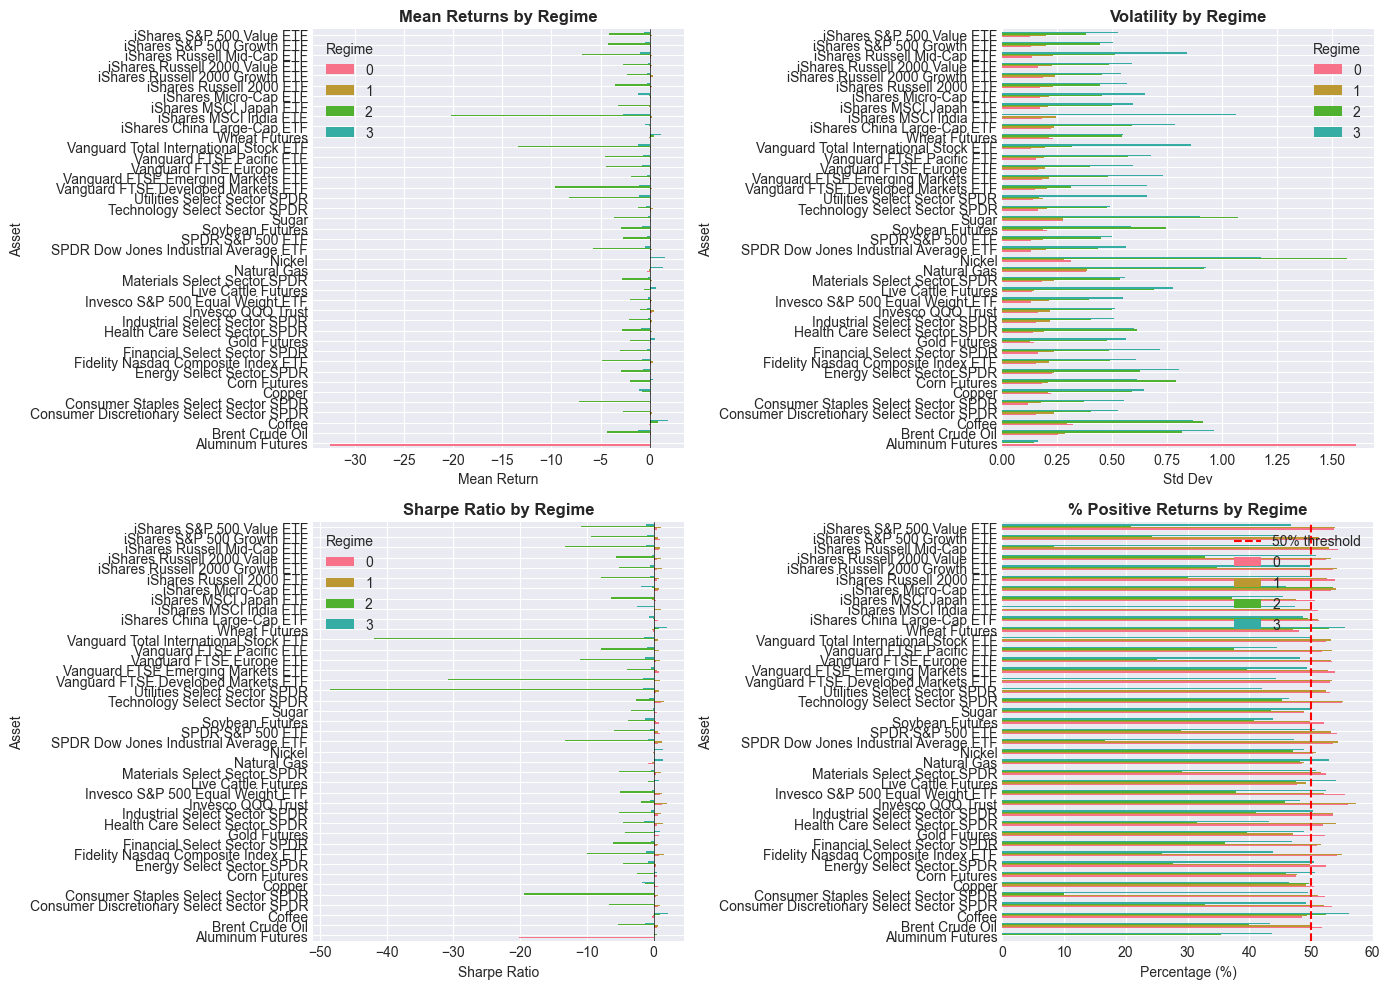

In [88]:
# Compare return characteristics across regimes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean returns by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Mean').plot.barh(ax=axes[0,0])
axes[0,0].set_title('Mean Returns by Regime', fontweight='bold')
axes[0,0].set_xlabel('Mean Return')
axes[0,0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Volatility by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Std').plot.barh(ax=axes[0,1])
axes[0,1].set_title('Volatility by Regime', fontweight='bold')
axes[0,1].set_xlabel('Std Dev')

# Sharpe ratio by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Sharpe').plot.barh(ax=axes[1,0])
axes[1,0].set_title('Sharpe Ratio by Regime', fontweight='bold')
axes[1,0].set_xlabel('Sharpe Ratio')
axes[1,0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Percentage positive by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Pct_Positive').plot.barh(ax=axes[1,1])
axes[1,1].set_title('% Positive Returns by Regime', fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')
axes[1,1].axvline(50, color='red', linestyle='--', label='50% threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [89]:
# Identify poorly differentiated regimes based on returns
print("Regime Differentiation Analysis:")
print("="*80)

for asset_name in regime_returns_df['Asset'].unique():
    asset_data = regime_returns_df[regime_returns_df['Asset'] == asset_name]
    
    if len(asset_data) >= 2:
        # Check if regimes have similar returns
        mean_diff = abs(asset_data['Mean'].max() - asset_data['Mean'].min())
        std_diff = abs(asset_data['Std'].max() - asset_data['Std'].min())
        
        # Flag if differences are small
        if mean_diff < 0.0005:  # Very small mean difference
            print(f"\n⚠️  {asset_name}: WEAK Mean Differentiation")
            print(f"   Mean difference: {mean_diff:.6f}")
            display(asset_data[['Regime', 'Mean', 'Std', 'Sharpe']])

Regime Differentiation Analysis:


## 10. Model Performance Metrics

In [90]:
def calculate_model_performance_metrics(models: Dict) -> pd.DataFrame:
    """
    Calculate performance metrics for all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Performance metrics for all models
    """
    performance_metrics = []
    
    for asset_name, model in models.items():
        try:
            returns = model.returns.dropna()
            regime_labels = model.regime_labels.dropna()
            
            # Align returns and regime_labels on common index
            common_idx = returns.index.intersection(regime_labels.index)
            returns_aligned = returns.loc[common_idx]
            regime_labels_aligned = regime_labels.loc[common_idx]
            
            # Number of parameters
            n_regimes = model.msr.n_regimes
            n_params = n_regimes * 3 + n_regimes * (n_regimes - 1)  # means, stds, betas, transition probs
            
            # Log-likelihood (approximate)
            log_likelihood = 0
            for regime in range(n_regimes):
                regime_mask = regime_labels_aligned == regime
                regime_returns = returns_aligned[regime_mask]
                if len(regime_returns) > 0:
                    ll = -0.5 * len(regime_returns) * np.log(2 * np.pi * model.msr.stds[regime]**2)
                    ll -= np.sum((regime_returns - model.msr.means[regime])**2) / (2 * model.msr.stds[regime]**2)
                    log_likelihood += ll
            
            # AIC and BIC
            n_obs = len(returns_aligned)
            aic = 2 * n_params - 2 * log_likelihood
            bic = n_params * np.log(n_obs) - 2 * log_likelihood
            
            metrics = {
                'Asset': asset_name,
                'Log_Likelihood': log_likelihood,
                'AIC': aic,
                'BIC': bic,
                'N_Params': n_params,
                'N_Obs': n_obs,
                'AIC_per_Obs': aic / n_obs,
                'BIC_per_Obs': bic / n_obs
            }
            
            performance_metrics.append(metrics)
            
        except Exception as e:
            print(f"❌ Error calculating performance metrics for {asset_name}: {str(e)}")
    
    return pd.DataFrame(performance_metrics)

performance_df = calculate_model_performance_metrics(models)

print("Model Performance Metrics:")
print("="*80)
if len(performance_df) > 0:
    display(performance_df.sort_values('BIC'))
else:
    print("❌ No performance metrics calculated")


Model Performance Metrics:


,Asset,Log_Likelihood,AIC,BIC,N_Params,N_Obs,AIC_per_Obs,BIC_per_Obs
23,Gold Futures,22585.6282,-45155.2564,-45099.2614,8,8098,-5.5761,-5.5692
24,Live Cattle Futures,21524.9011,-43033.8022,-42976.8634,8,9112,-4.7228,-4.7165
12,SPDR S&P 500 ETF,21371.9890,-42727.9781,-42672.8482,8,7268,-5.8789,-5.8713
28,Copper,19318.1711,-38620.3423,-38564.3453,8,8100,-4.7679,-4.7610
30,Soybean Futures,19214.5683,-38413.1366,-38357.1951,8,8044,-4.7754,-4.7684
22,Wheat Futures,19048.4951,-38080.9902,-38025.0239,8,8069,-4.7194,-4.7125
31,Corn Futures,17982.9932,-35949.9864,-35894.0409,8,8048,-4.4669,-4.4600
21,Sugar,17651.5203,-35287.0406,-35231.1210,8,8022,-4.3988,-4.3918
11,SPDR Dow Jones Industrial Average ETF,17602.3121,-35188.6242,-35135.0254,8,6002,-5.8628,-5.8539
1,Consumer Staples Select Sector SPDR,17281.2409,-34546.4818,-34493.1776,8,5785,-5.9717,-5.9625


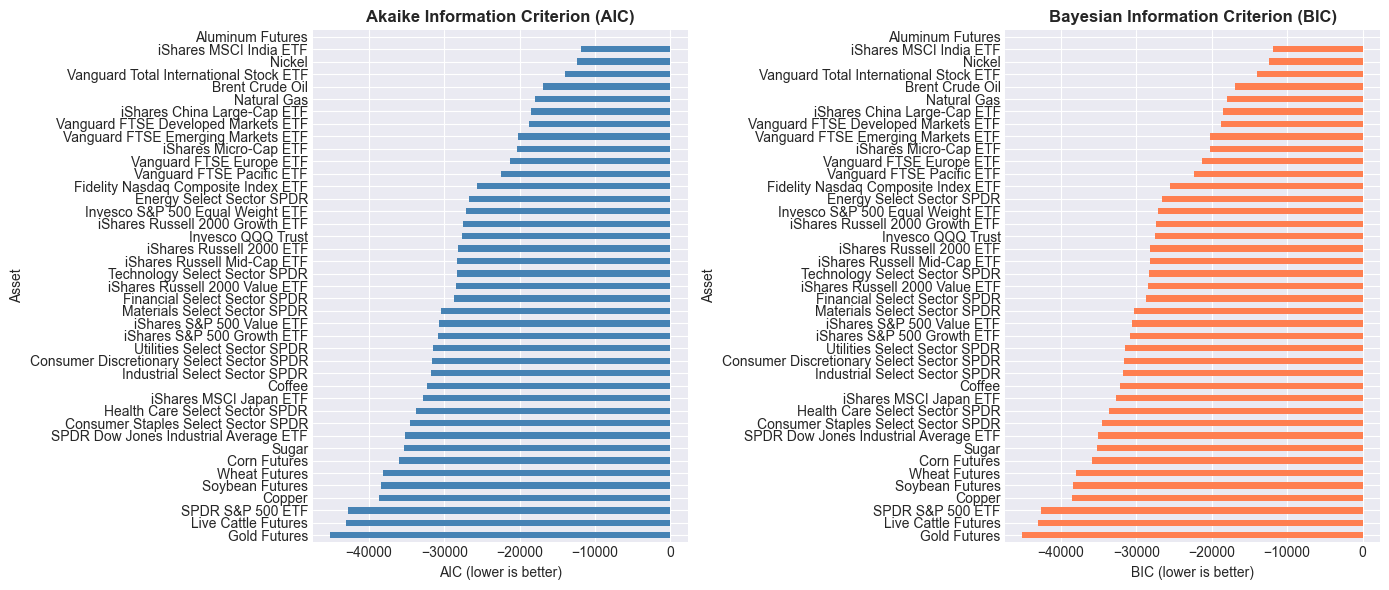


Best Performing Models (by BIC):


,Asset,Log_Likelihood,AIC,BIC
23,Gold Futures,22585.6282,-45155.2564,-45099.2614
24,Live Cattle Futures,21524.9011,-43033.8022,-42976.8634
12,SPDR S&P 500 ETF,21371.9890,-42727.9781,-42672.8482
28,Copper,19318.1711,-38620.3423,-38564.3453
30,Soybean Futures,19214.5683,-38413.1366,-38357.1951



Worst Performing Models (by BIC):


,Asset,Log_Likelihood,AIC,BIC
32,Aluminum Futures,0.9037,14.1925,58.7561
38,iShares MSCI India ETF,5957.0580,-11898.1161,-11851.5847
25,Nickel,6216.7464,-12417.4929,-12368.3053
33,Vanguard Total International Stock ETF,7019.8726,-14023.7452,-13976.4049
29,Brent Crude Oil,8470.5022,-16925.0045,-16874.6841


In [91]:
# Visualize performance metrics
if len(performance_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # AIC
    performance_df.sort_values('AIC').plot.barh(x='Asset', y='AIC', ax=axes[0], 
                                                 color='steelblue', legend=False)
    axes[0].set_title('Akaike Information Criterion (AIC)', fontweight='bold')
    axes[0].set_xlabel('AIC (lower is better)')

    # BIC
    performance_df.sort_values('BIC').plot.barh(x='Asset', y='BIC', ax=axes[1], 
                                                 color='coral', legend=False)
    axes[1].set_title('Bayesian Information Criterion (BIC)', fontweight='bold')
    axes[1].set_xlabel('BIC (lower is better)')

    plt.tight_layout()
    plt.show()

    print("\nBest Performing Models (by BIC):")
    display(performance_df.nsmallest(5, 'BIC')[['Asset', 'Log_Likelihood', 'AIC', 'BIC']])

    print("\nWorst Performing Models (by BIC):")
    display(performance_df.nlargest(5, 'BIC')[['Asset', 'Log_Likelihood', 'AIC', 'BIC']])
else:
    print("❌ No performance data to visualize")


## 11. Regime Stability Analysis

In [92]:
# Combine with earlier duration metrics
stability_df = metadata_df[['Asset', 'N_Regime_Changes', 'Avg_Regime_Duration']].merge(
    duration_df[['Asset', 'Pct_Single_Period', 'Std_Duration']], 
    on='Asset'
)

# Add regime change frequency
stability_df['Changes_Per_100_Periods'] = (stability_df['N_Regime_Changes'] / 
                                           metadata_df['N_Data_Points'] * 100)

print("Regime Stability Metrics:")
print("="*80)
display(stability_df.sort_values('Changes_Per_100_Periods', ascending=False))

Regime Stability Metrics:


,Asset,N_Regime_Changes,Avg_Regime_Duration,Pct_Single_Period,Std_Duration,Changes_Per_100_Periods
24,Live Cattle Futures,1422,6.4034,14.9684,12.1621,15.5546
26,Natural Gas,682,8.0220,10.3953,7.4071,12.4339
21,Sugar,742,10.7968,19.1117,12.5884,9.2403
2,iShares Micro-Cap ETF,255,16.0742,2.3438,13.1898,6.1833
27,Coffee,493,16.2186,8.5020,16.8604,6.1433
31,Corn Futures,429,18.7163,13.0233,33.6753,5.3265
22,Wheat Futures,372,21.6327,10.1877,29.3603,4.6040
32,Aluminum Futures,83,23.0952,7.1429,79.5878,4.2652
33,Vanguard Total International Stock ETF,95,28.5938,11.4583,47.1836,3.4533
30,Soybean Futures,240,33.3776,15.7676,58.8235,2.9721


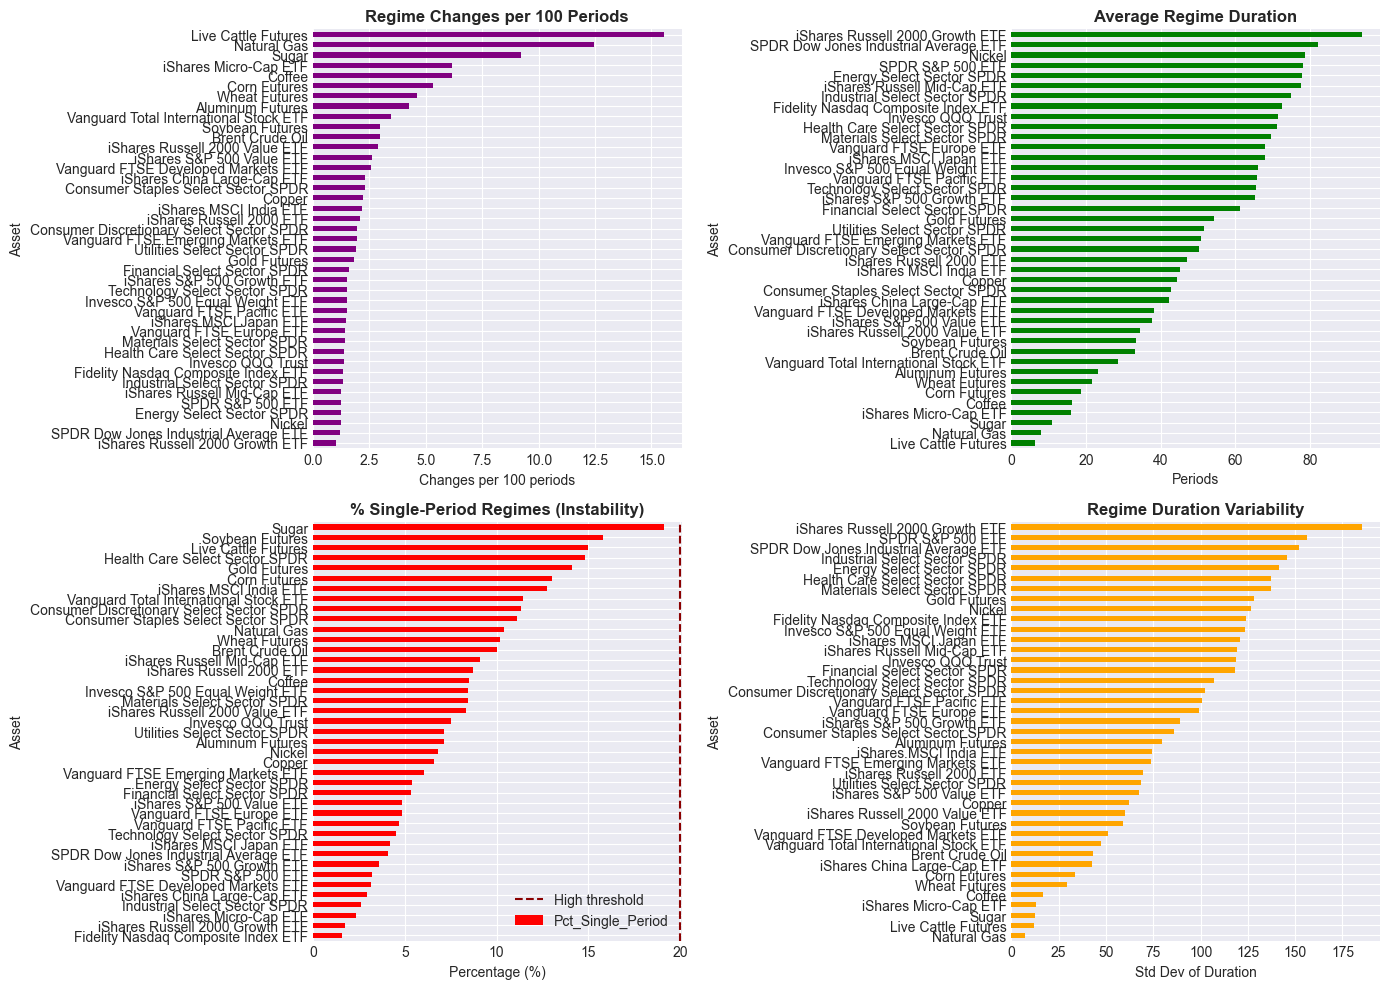

In [93]:
# Visualize stability metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Regime changes per 100 periods
stability_df.sort_values('Changes_Per_100_Periods').plot.barh(
    x='Asset', y='Changes_Per_100_Periods', ax=axes[0,0], color='purple', legend=False
)
axes[0,0].set_title('Regime Changes per 100 Periods', fontweight='bold')
axes[0,0].set_xlabel('Changes per 100 periods')

# Average regime duration
stability_df.sort_values('Avg_Regime_Duration').plot.barh(
    x='Asset', y='Avg_Regime_Duration', ax=axes[0,1], color='green', legend=False
)
axes[0,1].set_title('Average Regime Duration', fontweight='bold')
axes[0,1].set_xlabel('Periods')

# Percentage single-period regimes
stability_df.sort_values('Pct_Single_Period').plot.barh(
    x='Asset', y='Pct_Single_Period', ax=axes[1,0], color='red', legend=False
)
axes[1,0].set_title('% Single-Period Regimes (Instability)', fontweight='bold')
axes[1,0].set_xlabel('Percentage (%)')
axes[1,0].axvline(20, color='darkred', linestyle='--', label='High threshold')
axes[1,0].legend()

# Duration variability
stability_df.sort_values('Std_Duration').plot.barh(
    x='Asset', y='Std_Duration', ax=axes[1,1], color='orange', legend=False
)
axes[1,1].set_title('Regime Duration Variability', fontweight='bold')
axes[1,1].set_xlabel('Std Dev of Duration')

plt.tight_layout()
plt.show()

In [94]:
# Identify unstable models
print("Models with Stability Issues:")
print("="*80)

print("\n1. HIGH REGIME SWITCHING (>15 changes per 100 periods):")
high_switching = stability_df[stability_df['Changes_Per_100_Periods'] > 15].sort_values(
    'Changes_Per_100_Periods', ascending=False
)
if len(high_switching) > 0:
    display(high_switching)
else:
    print("  ✓ None found")

print("\n2. HIGH INSTABILITY (>20% single-period regimes):")
high_instability = stability_df[stability_df['Pct_Single_Period'] > 20].sort_values(
    'Pct_Single_Period', ascending=False
)
if len(high_instability) > 0:
    display(high_instability)
else:
    print("  ✓ None found")

Models with Stability Issues:

1. HIGH REGIME SWITCHING (>15 changes per 100 periods):


,Asset,N_Regime_Changes,Avg_Regime_Duration,Pct_Single_Period,Std_Duration,Changes_Per_100_Periods
24,Live Cattle Futures,1422,6.4034,14.9684,12.1621,15.5546



2. HIGH INSTABILITY (>20% single-period regimes):
  ✓ None found


## 12. Parameter Sensitivity Visualization

In [95]:
# Merge all dataframes for comprehensive analysis
comprehensive_df = metadata_df.merge(duration_df, on='Asset', suffixes=('', '_dur'))
comprehensive_df = comprehensive_df.merge(performance_df, on='Asset')
comprehensive_df = comprehensive_df.merge(stability_df[['Asset', 'Changes_Per_100_Periods']], on='Asset')

print("Comprehensive Dataset Shape:", comprehensive_df.shape)
print("\nFirst few rows:")
display(comprehensive_df.head())

Comprehensive Dataset Shape: (41, 50)

First few rows:


,Asset,N_Data_Points,N_MSR_Regimes,N_Combined_Regimes,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma,N_Regime_Changes,Avg_Regime_Duration,Regime_0_Pct,Regime_0_Count,Regime_1_Pct,Regime_1_Count,Regime_2_Pct,Regime_2_Count,Regime_3_Pct,Regime_3_Count,MSR_Mean_0,MSR_Std_0,MSR_Beta_0,MSR_Mean_1,MSR_Std_1,MSR_Beta_1,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1,Mean_Diff,Std_Diff,Regime_Diversity_Score,Persistence_0,Persistence_1,Mean_Duration,Median_Duration,Std_Duration,Min_Duration,Max_Duration,Q25_Duration,Q75_Duration,N_Regimes,Pct_Single_Period,Log_Likelihood,AIC,BIC,N_Params,N_Obs,AIC_per_Obs,BIC_per_Obs,Changes_Per_100_Periods
0,Consumer Discretionary Select Sector SPDR,5795,2,4,16,10,50,0.5,114,50.2435,74.1260,4283,17.5320,1013,1.0557,61,7.2863,421,0.0005,0.0125,-0.0062,-0.0012,0.0370,-0.0170,0.9931,0.0069,0.0693,0.9307,0.0017,0.0245,0.4474,0.9931,0.9307,50.2348,15.0,102.3424,1,721,3.00,40.5,115,11.3043,15848.2866,-31680.5732,-31627.2787,8,5778,-5.4830,-5.4737,1.9672
1,Consumer Staples Select Sector SPDR,5795,2,4,9,10,60,0.5,134,42.8519,71.9965,4165,25.7736,1491,0.1729,10,2.0570,119,0.0002,0.0103,-0.0196,-0.0018,0.0492,-0.0189,0.9951,0.0049,0.1785,0.8215,0.0021,0.0389,0.5117,0.9951,0.8215,42.8444,12.0,85.9443,1,579,4.00,36.0,135,11.1111,17281.2409,-34546.4818,-34493.1776,8,5785,-5.9717,-5.9625,2.3123
2,iShares Micro-Cap ETF,4124,2,4,8,2,40,2.0,255,16.0742,54.8481,2257,36.5735,1505,3.4022,140,5.1762,213,0.0005,0.0140,-0.0038,-0.0027,0.0436,-0.0531,0.9954,0.0046,0.0491,0.9509,0.0032,0.0296,0.3035,0.9954,0.9509,16.0703,12.0,13.1898,1,69,6.75,22.0,256,2.3438,10162.4360,-20308.8720,-20258.2929,8,4115,-4.9353,-4.9230,6.1833
3,Invesco S&P 500 Equal Weight ETF,4703,2,4,10,10,50,1.0,70,66.0845,79.5183,3731,12.3615,580,0.9591,45,7.1611,336,0.0006,0.0114,-0.0053,-0.0018,0.0401,-0.0391,0.9960,0.0040,0.0427,0.9573,0.0024,0.0287,0.5138,0.9960,0.9573,66.0704,14.0,123.6892,1,582,5.00,60.0,71,8.4507,13586.8230,-27157.6461,-27106.0172,8,4692,-5.7881,-5.7771,1.4884
4,iShares Russell 2000 ETF,5435,2,4,12,10,30,0.5,114,47.1478,66.1011,3584,25.8576,1402,0.5533,30,7.4880,406,0.0005,0.0135,-0.0142,-0.0020,0.0408,-0.0494,0.9958,0.0042,0.0473,0.9527,0.0025,0.0273,0.3896,0.9958,0.9527,47.1391,21.0,69.5128,1,358,6.50,47.5,115,8.6957,14102.1226,-28188.2453,-28135.4595,8,5422,-5.1989,-5.1891,2.0975


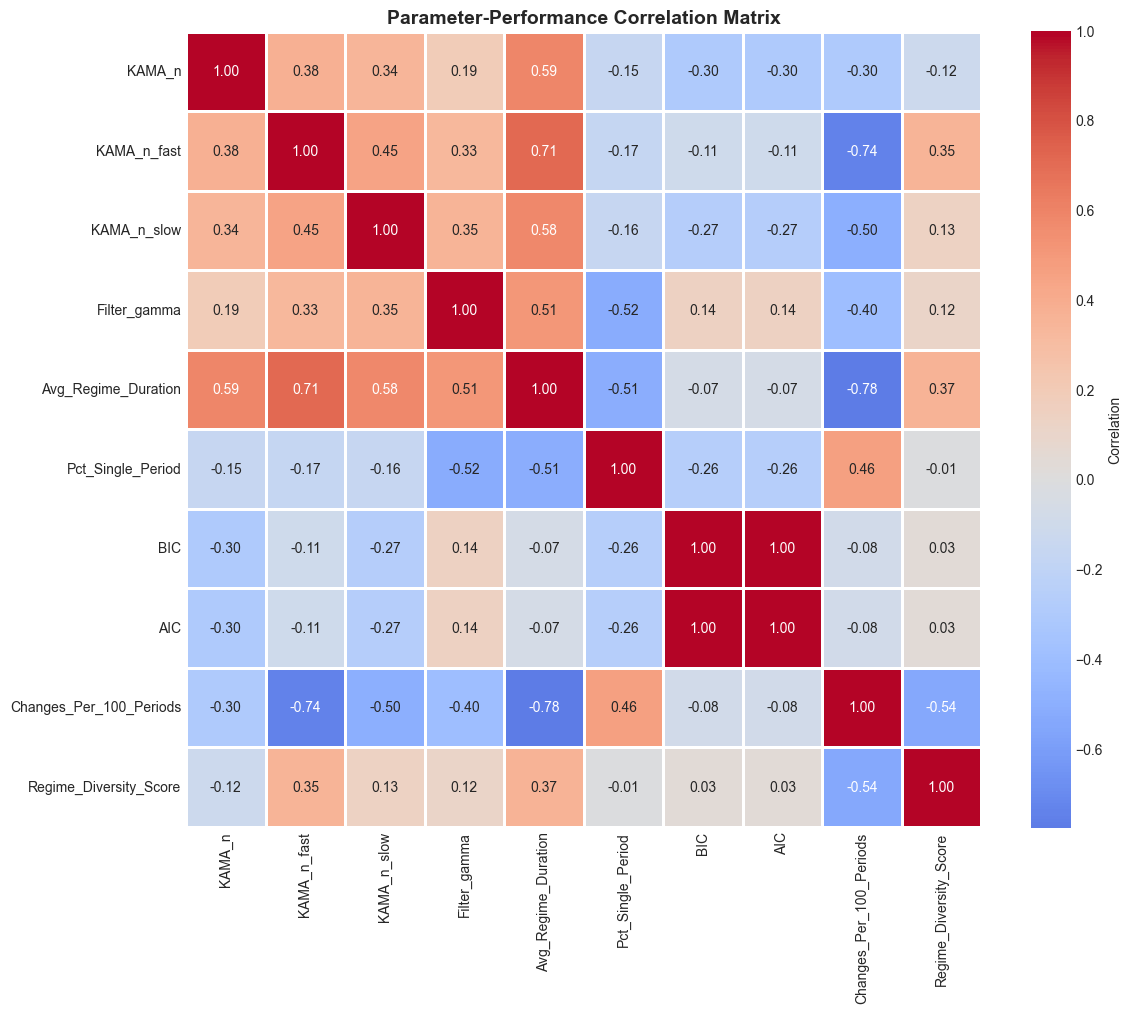


Strongest Correlations with Performance Metrics:

Correlations with BIC (model quality):
  AIC: 1.000
  KAMA_n: -0.301
  KAMA_n_slow: -0.270
  Pct_Single_Period: -0.258
  Filter_gamma: 0.142


In [96]:
# Correlation matrix of key parameters and performance metrics
key_columns = [
    'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma',
    'Avg_Regime_Duration', 'Pct_Single_Period',
    'BIC', 'AIC', 'Changes_Per_100_Periods',
    'Regime_Diversity_Score'
]

# Filter columns that exist
available_cols = [col for col in key_columns if col in comprehensive_df.columns]

correlation_matrix = comprehensive_df[available_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Parameter-Performance Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrongest Correlations with Performance Metrics:")
print("="*80)

# Find strongest correlations with BIC
if 'BIC' in correlation_matrix.columns:
    bic_corr = correlation_matrix['BIC'].drop('BIC').abs().sort_values(ascending=False)
    print("\nCorrelations with BIC (model quality):")
    for param, corr in bic_corr.head(5).items():
        print(f"  {param}: {correlation_matrix.loc[param, 'BIC']:.3f}")

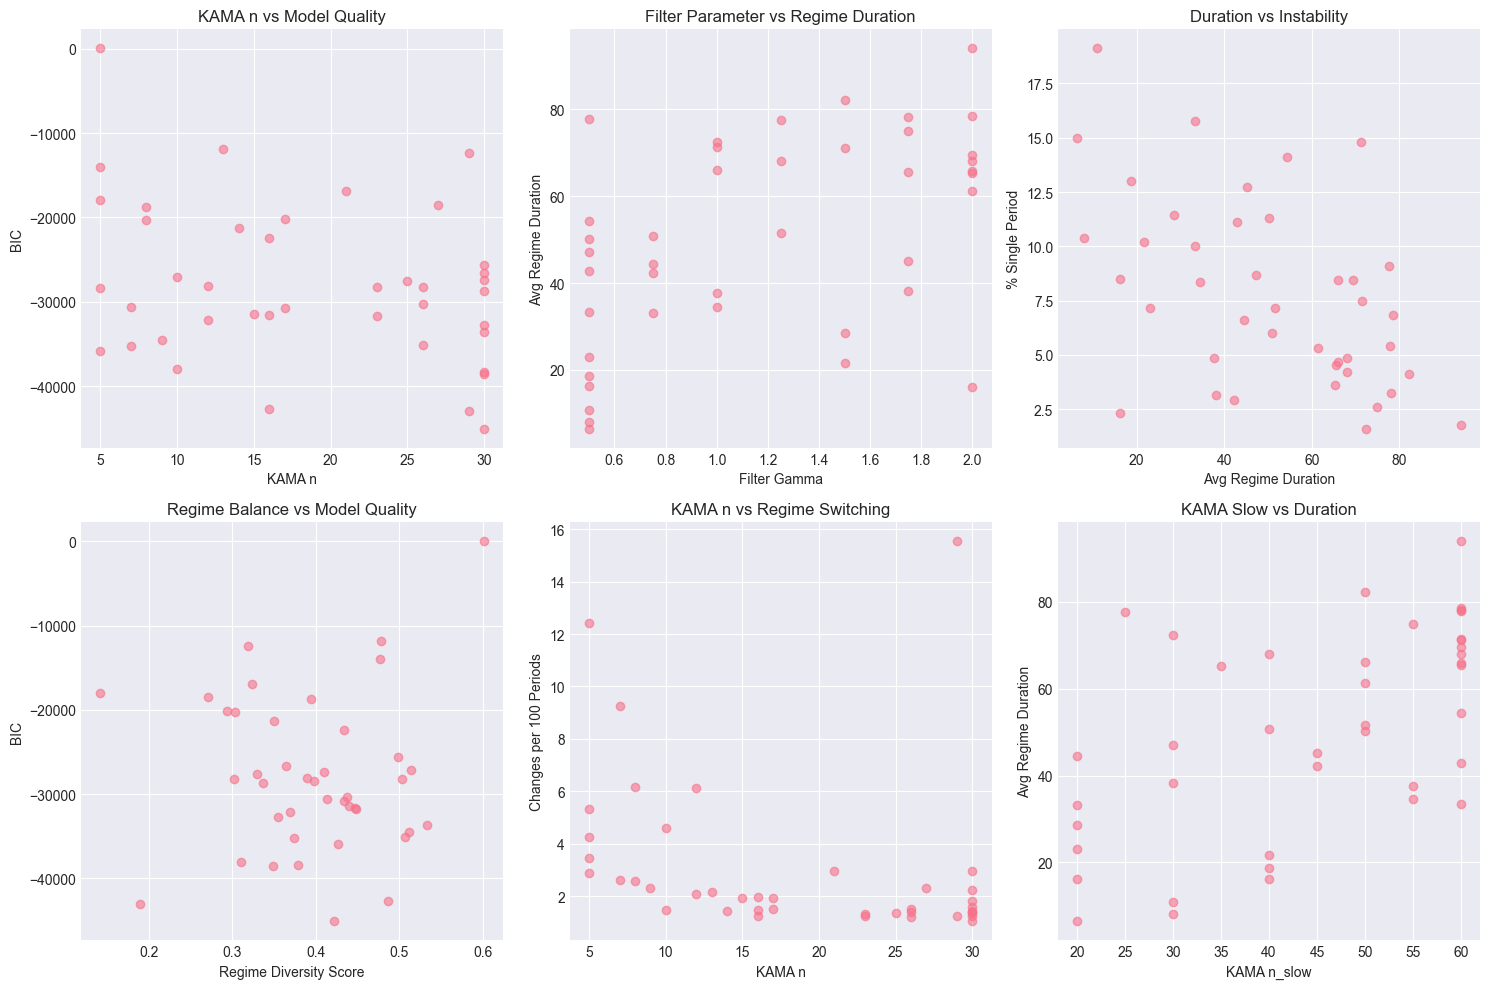

In [97]:
# Scatter plots of key relationships
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# KAMA_n vs BIC
if 'BIC' in comprehensive_df.columns:
    axes[0,0].scatter(comprehensive_df['KAMA_n'], comprehensive_df['BIC'], alpha=0.6)
    axes[0,0].set_xlabel('KAMA n')
    axes[0,0].set_ylabel('BIC')
    axes[0,0].set_title('KAMA n vs Model Quality')

# Filter gamma vs Avg Duration
axes[0,1].scatter(comprehensive_df['Filter_gamma'], comprehensive_df['Avg_Regime_Duration'], alpha=0.6)
axes[0,1].set_xlabel('Filter Gamma')
axes[0,1].set_ylabel('Avg Regime Duration')
axes[0,1].set_title('Filter Parameter vs Regime Duration')

# Avg Duration vs Single Period %
axes[0,2].scatter(comprehensive_df['Avg_Regime_Duration'], comprehensive_df['Pct_Single_Period'], alpha=0.6)
axes[0,2].set_xlabel('Avg Regime Duration')
axes[0,2].set_ylabel('% Single Period')
axes[0,2].set_title('Duration vs Instability')

# Diversity Score vs BIC
if 'BIC' in comprehensive_df.columns and 'Regime_Diversity_Score' in comprehensive_df.columns:
    axes[1,0].scatter(comprehensive_df['Regime_Diversity_Score'], comprehensive_df['BIC'], alpha=0.6)
    axes[1,0].set_xlabel('Regime Diversity Score')
    axes[1,0].set_ylabel('BIC')
    axes[1,0].set_title('Regime Balance vs Model Quality')

# KAMA_n vs Changes per 100
axes[1,1].scatter(comprehensive_df['KAMA_n'], comprehensive_df['Changes_Per_100_Periods'], alpha=0.6)
axes[1,1].set_xlabel('KAMA n')
axes[1,1].set_ylabel('Changes per 100 Periods')
axes[1,1].set_title('KAMA n vs Regime Switching')
# KAMA n_slow vs Avg Duration
axes[1,2].scatter(comprehensive_df['KAMA_n_slow'], comprehensive_df['Avg_Regime_Duration'], alpha=0.6)
axes[1,2].set_xlabel('KAMA n_slow')
axes[1,2].set_ylabel('Avg Regime Duration')
axes[1,2].set_title('KAMA Slow vs Duration')

plt.tight_layout()
plt.show()

## 13. Cross-Asset Regime Correlation

In [98]:
def build_regime_label_matrix(models: Dict) -> pd.DataFrame:
    """
    Build a matrix of regime labels across all assets.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Matrix with dates as index and assets as columns containing regime labels
    """
    regime_data = {}
    
    for asset_name, model in models.items():
        regime_data[asset_name] = model.regime_labels
    
    regime_matrix = pd.DataFrame(regime_data)
    return regime_matrix

regime_matrix = build_regime_label_matrix(models)

print("Regime Label Matrix:")
print("="*80)
print(f"Shape: {regime_matrix.shape}")
print(f"Date range: {regime_matrix.index.min()} to {regime_matrix.index.max()}")
print("\Last few rows:")
display(regime_matrix.tail())

Regime Label Matrix:
Shape: (9823, 41)
Date range: 1990-01-02 00:00:00 to 2021-12-31 00:00:00
\Last few rows:


,Consumer Discretionary Select Sector SPDR,Consumer Staples Select Sector SPDR,iShares Micro-Cap ETF,Invesco S&P 500 Equal Weight ETF,iShares Russell 2000 ETF,Financial Select Sector SPDR,iShares S&P 500 Value ETF,Health Care Select Sector SPDR,iShares Russell 2000 Value ETF,iShares S&P 500 Growth ETF,Invesco QQQ Trust,SPDR Dow Jones Industrial Average ETF,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,iShares Russell Mid-Cap ETF,Technology Select Sector SPDR,Fidelity Nasdaq Composite Index ETF,Energy Select Sector SPDR,Materials Select Sector SPDR,Utilities Select Sector SPDR,Industrial Select Sector SPDR,Sugar,Wheat Futures,Gold Futures,Live Cattle Futures,Nickel,Natural Gas,Coffee,Copper,Brent Crude Oil,Soybean Futures,Corn Futures,Aluminum Futures,Vanguard Total International Stock ETF,Vanguard FTSE Europe ETF,iShares MSCI Japan ETF,Vanguard FTSE Pacific ETF,Vanguard FTSE Emerging Markets ETF,iShares MSCI India ETF,iShares China Large-Cap ETF,Vanguard FTSE Developed Markets ETF
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-27,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,<NA>,3,1,0,1,0,1,2,1,0,0,0,1,0,1,1
2021-12-28,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,<NA>,2,1,0,1,0,1,2,1,0,0,0,1,0,1,1
2021-12-29,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,<NA>,2,1,0,1,0,1,2,1,0,0,0,1,0,1,1
2021-12-30,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,<NA>,2,1,0,1,0,1,2,1,0,0,0,1,0,1,1
2021-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,<NA>,3,1,0,1,0,1,2,1,0,0,0,1,0,1,1


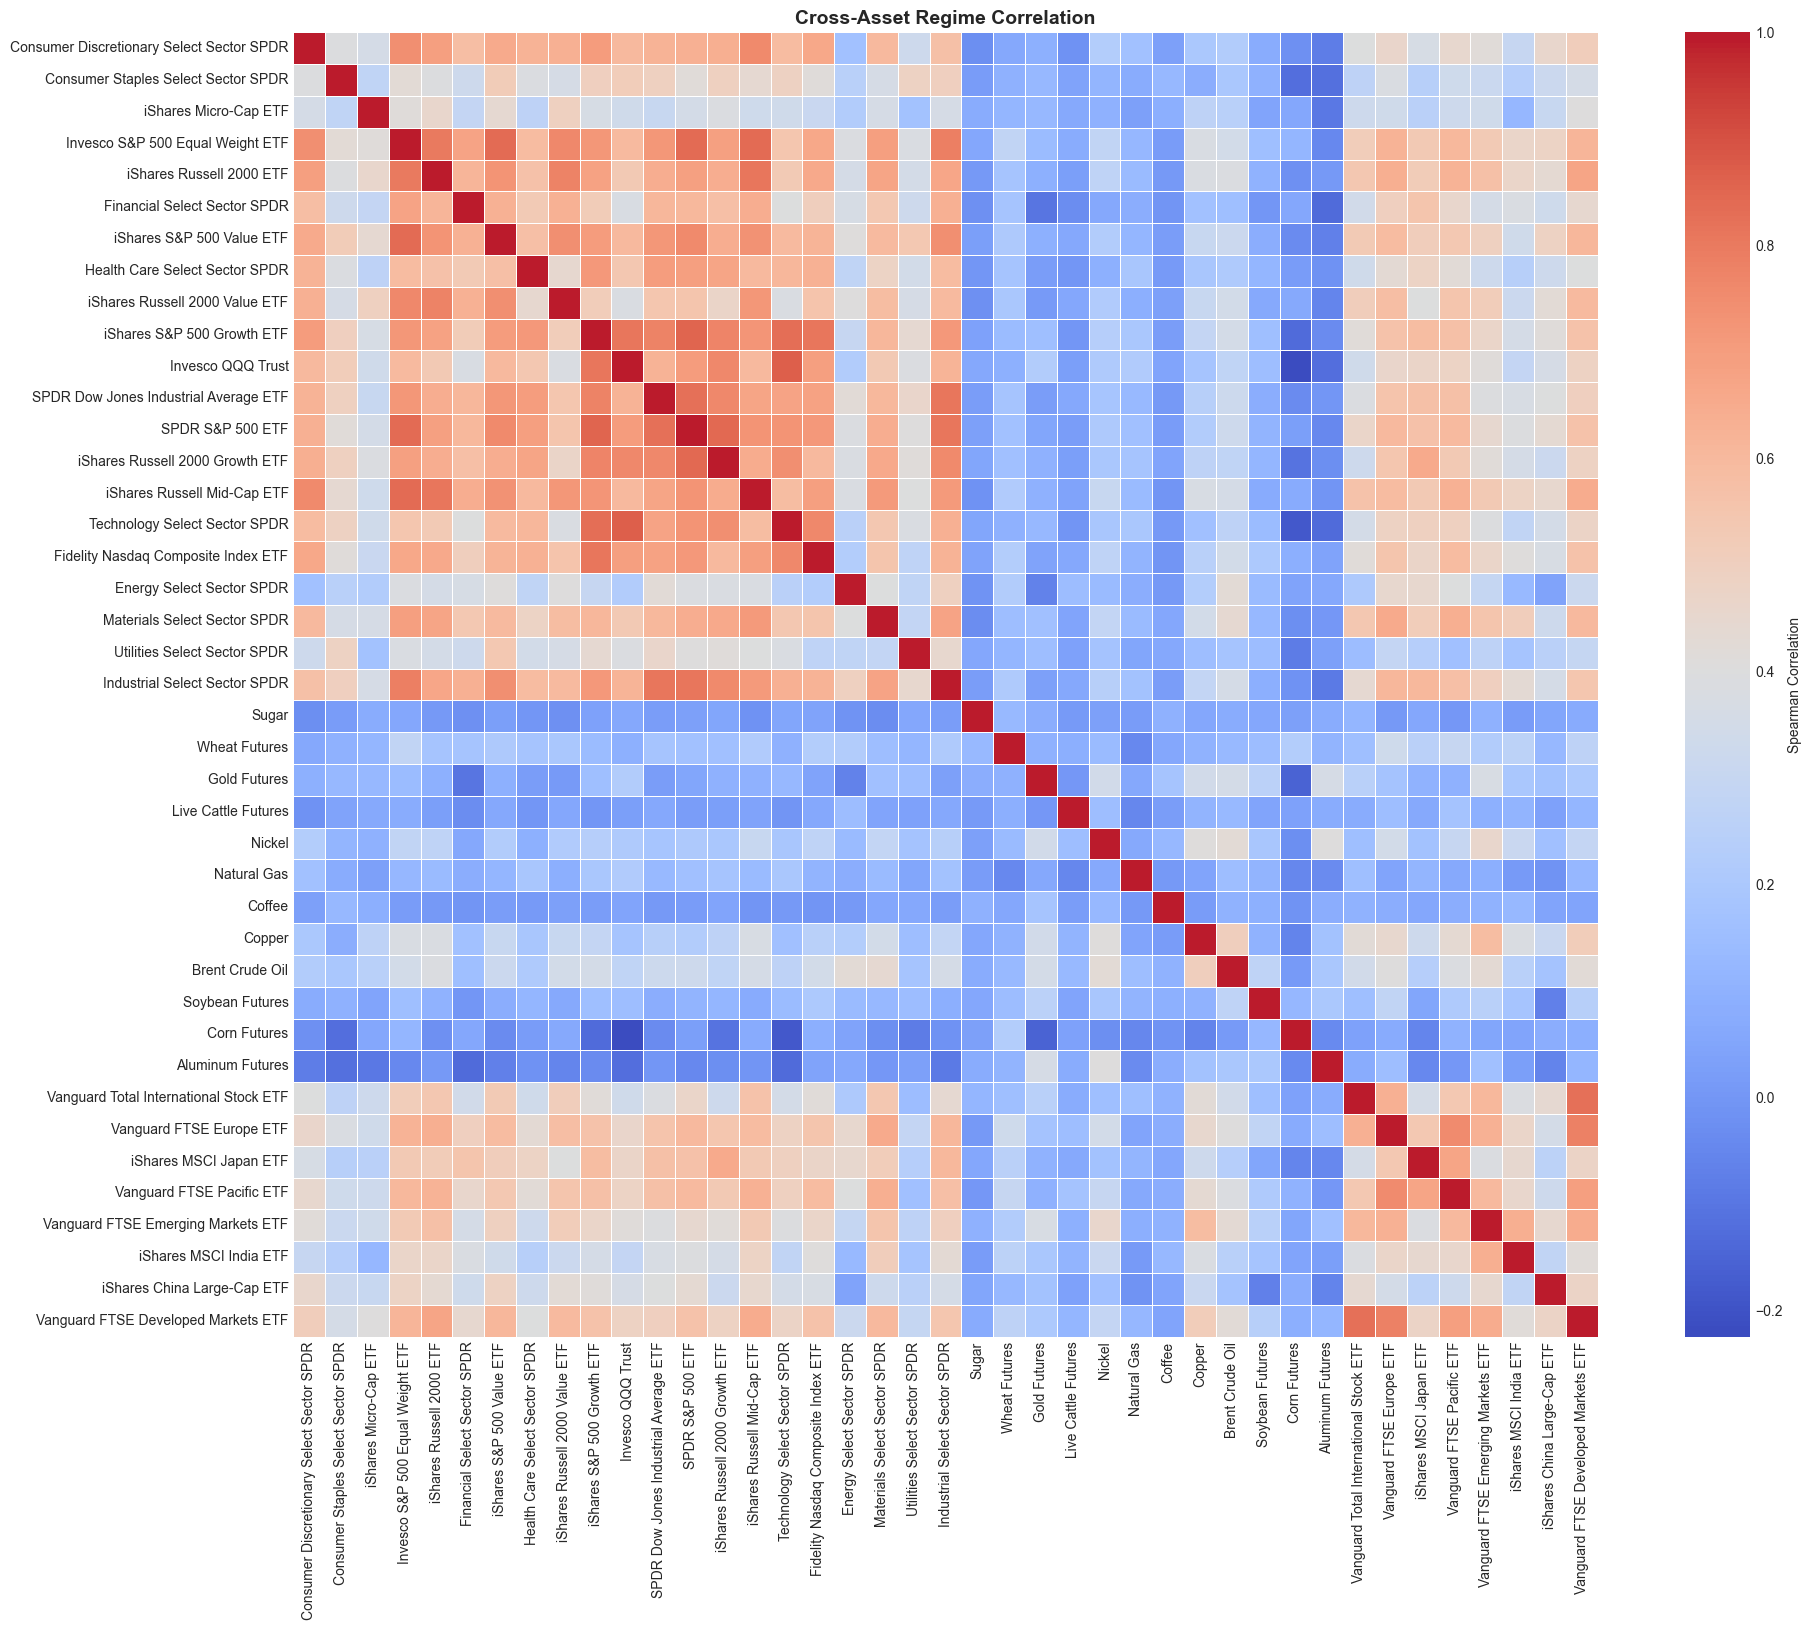


Strongest Cross-Asset Regime Correlations:

Highest Positive Correlations:


,Asset 1,Asset 2,Correlation
115,Invesco QQQ Trust,Technology Select Sector SPDR,0.8696
75,iShares S&P 500 Growth ETF,SPDR S&P 500 ETF,0.8562
90,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,0.8457
94,Invesco S&P 500 Equal Weight ETF,iShares Russell Mid-Cap ETF,0.8391
18,Invesco S&P 500 Equal Weight ETF,iShares S&P 500 Value ETF,0.8385
69,Invesco S&P 500 Equal Weight ETF,SPDR S&P 500 ETF,0.8380
114,iShares S&P 500 Growth ETF,Technology Select Sector SPDR,0.8301
77,SPDR Dow Jones Industrial Average ETF,SPDR S&P 500 ETF,0.8268
813,Vanguard Total International Stock ETF,Vanguard FTSE Developed Markets ETF,0.8259
129,iShares S&P 500 Growth ETF,Fidelity Nasdaq Composite Index ETF,0.8128



Highest Negative Correlations:


,Asset 1,Asset 2,Correlation
478,iShares Russell 2000 Growth ETF,Corn Futures,-0.1080
497,Consumer Staples Select Sector SPDR,Aluminum Futures,-0.1186
506,Invesco QQQ Trust,Aluminum Futures,-0.1214
466,Consumer Staples Select Sector SPDR,Corn Futures,-0.1237
511,Technology Select Sector SPDR,Aluminum Futures,-0.1296
474,iShares S&P 500 Growth ETF,Corn Futures,-0.1306
501,Financial Select Sector SPDR,Aluminum Futures,-0.1324
488,Gold Futures,Corn Futures,-0.1562
480,Technology Select Sector SPDR,Corn Futures,-0.1826
475,Invesco QQQ Trust,Corn Futures,-0.2244


In [105]:
# Calculate regime correlation (using aligned dates only)
regime_corr = regime_matrix.corr(method='spearman')  # Spearman for ordinal data

plt.figure(figsize=(max(10, len(models)*0.5), max(8, len(models)*0.4)))
sns.heatmap(regime_corr, annot=False, cmap='coolwarm', center=0.4, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})
plt.title('Cross-Asset Regime Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrongest Cross-Asset Regime Correlations:")
print("="*80)

# Get upper triangle to avoid duplicates
mask = np.triu(np.ones_like(regime_corr, dtype=bool), k=1)
regime_corr_upper = regime_corr.where(mask)

# Find top correlations
correlations = []
for col in regime_corr_upper.columns:
    for idx in regime_corr_upper.index:
        val = regime_corr_upper.loc[idx, col]
        if not pd.isna(val):
            correlations.append({
                'Asset 1': idx,
                'Asset 2': col,
                'Correlation': val
            })

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
print("\nHighest Positive Correlations:")
display(corr_df.head(10))

print("\nHighest Negative Correlations:")
display(corr_df.tail(10))

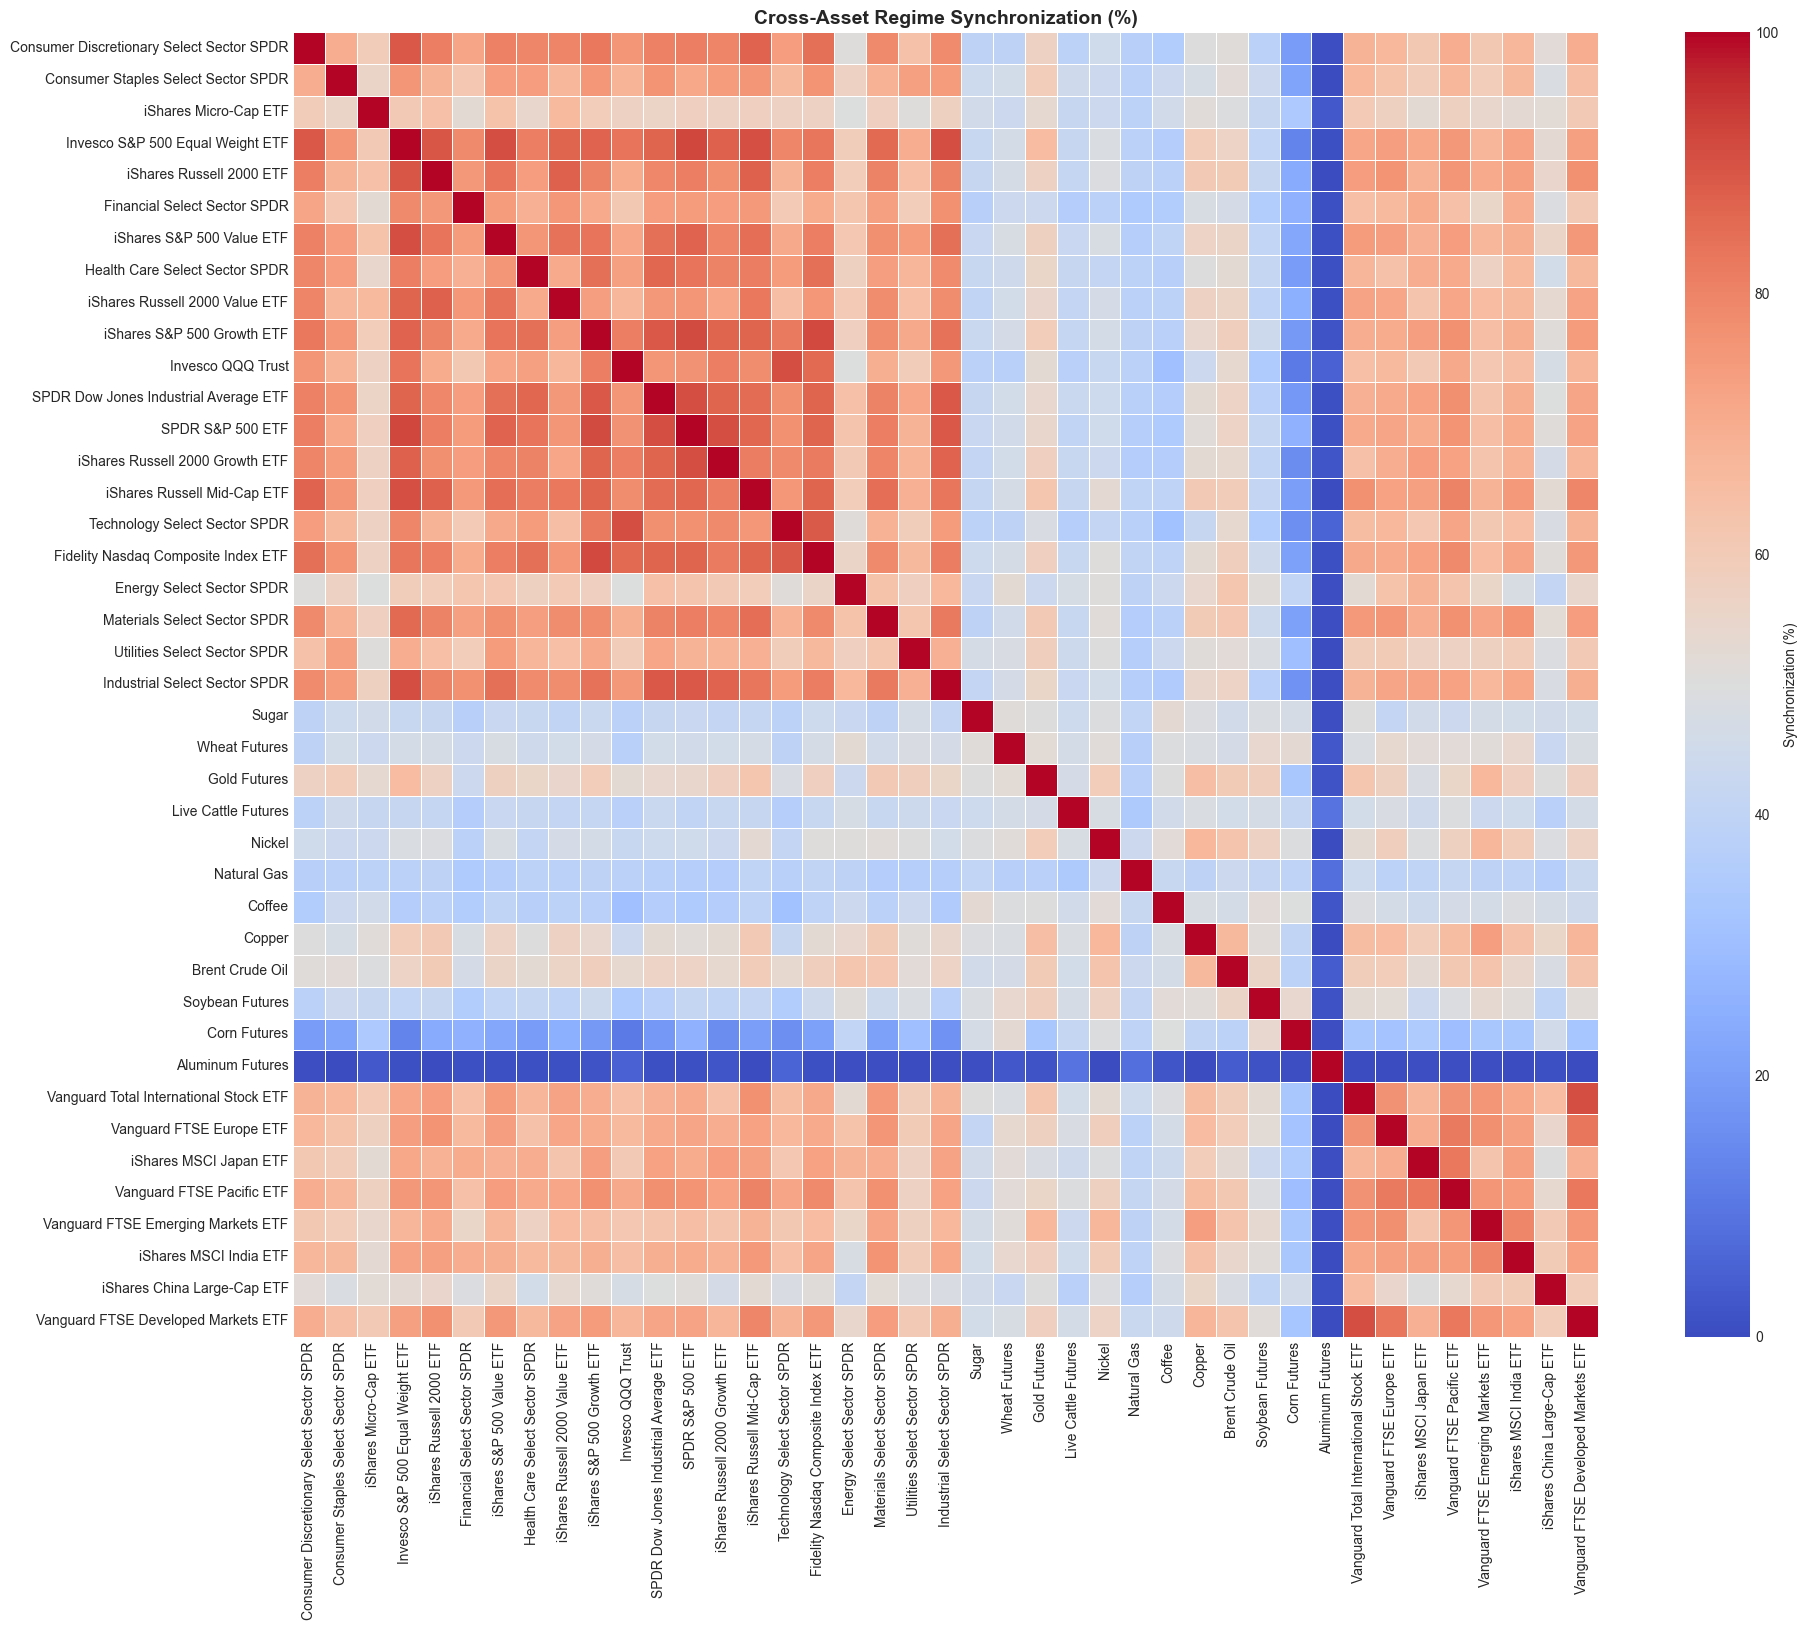


Asset Pairs with Highest Regime Synchronization:


,Asset 1,Asset 2,Sync %
125,Invesco S&P 500 Equal Weight ETF,SPDR S&P 500 ETF,91.8585
330,iShares S&P 500 Growth ETF,Fidelity Nasdaq Composite Index ETF,91.5882
326,iShares S&P 500 Growth ETF,SPDR S&P 500 ETF,91.3421
798,Vanguard Total International Stock ETF,Vanguard FTSE Developed Markets ETF,90.9290
119,Invesco S&P 500 Equal Weight ETF,iShares S&P 500 Value ETF,90.8994
385,SPDR Dow Jones Industrial Average ETF,SPDR S&P 500 ETF,90.8031
133,Invesco S&P 500 Equal Weight ETF,Industrial Select Sector SPDR,90.7928
359,Invesco QQQ Trust,Technology Select Sector SPDR,90.7469
414,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,90.6547
127,Invesco S&P 500 Equal Weight ETF,iShares Russell Mid-Cap ETF,90.5371


In [100]:
# Calculate regime synchronization percentage
def calculate_regime_sync(regime_matrix: pd.DataFrame) -> pd.DataFrame:
    """Calculate percentage of time assets are in the same regime."""
    assets = regime_matrix.columns
    n_assets = len(assets)
    
    sync_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)
    
    for i, asset1 in enumerate(assets):
        for j, asset2 in enumerate(assets):
            if i == j:
                sync_matrix.loc[asset1, asset2] = 100.0
            else:
                # Find common dates
                common_dates = regime_matrix[[asset1, asset2]].dropna().index
                if len(common_dates) > 0:
                    same_regime = (regime_matrix.loc[common_dates, asset1] == 
                                  regime_matrix.loc[common_dates, asset2])
                    sync_matrix.loc[asset1, asset2] = same_regime.sum() / len(common_dates) * 100
    
    return sync_matrix.astype(float)

sync_matrix = calculate_regime_sync(regime_matrix)

plt.figure(figsize=(max(10, len(models)*0.5), max(8, len(models)*0.4)))
sns.heatmap(sync_matrix, annot=False, fmt='.1f', cmap='coolwarm', 
            vmin=0, vmax=100, square=True, linewidths=0.5,
            cbar_kws={'label': 'Synchronization (%)'})
plt.title('Cross-Asset Regime Synchronization (%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAsset Pairs with Highest Regime Synchronization:")
print("="*80)

# Convert to long format
sync_data = []
for i, asset1 in enumerate(sync_matrix.index):
    for j, asset2 in enumerate(sync_matrix.columns):
        if i < j:  # Upper triangle only
            sync_data.append({
                'Asset 1': asset1,
                'Asset 2': asset2,
                'Sync %': sync_matrix.loc[asset1, asset2]
            })

sync_df = pd.DataFrame(sync_data).sort_values('Sync %', ascending=False)
display(sync_df.head(10))

## 14. Identify Outliers and Anomalies

In [101]:
def identify_outliers_zscore(df: pd.DataFrame, columns: list, threshold: float = 3.0) -> pd.DataFrame:
    """
    Identify outliers using z-score method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to analyze
    columns : list
        Columns to check for outliers
    threshold : float
        Z-score threshold (default: 3.0)
    
    Returns:
    --------
    pd.DataFrame : Rows with outlier values
    """
    outliers = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            col_outliers = df[z_scores > threshold]
            
            if len(col_outliers) > 0:
                col_outliers['Outlier_Column'] = col
                col_outliers['Z_Score'] = z_scores[z_scores > threshold]
                outliers = pd.concat([outliers, col_outliers])
    
    return outliers

# Define columns to check
outlier_check_columns = [
    'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma',
    'Avg_Regime_Duration', 'Pct_Single_Period',
    'BIC', 'Changes_Per_100_Periods',
    'Regime_Diversity_Score'
]

# Filter available columns
available_outlier_cols = [col for col in outlier_check_columns if col in comprehensive_df.columns]

outliers = identify_outliers_zscore(comprehensive_df, available_outlier_cols, threshold=2.5)

print("Outlier Analysis (Z-score > 2.5):")
print("="*80)

if len(outliers) > 0:
    outlier_summary = outliers.groupby('Asset')['Outlier_Column'].apply(list).reset_index()
    outlier_summary.columns = ['Asset', 'Outlier Parameters']
    display(outlier_summary)
    
    print("\nDetailed Outlier Information:")
    display(outliers[['Asset', 'Outlier_Column', 'Z_Score']].sort_values('Z_Score', ascending=False))
else:
    print("✓ No significant outliers found")

Outlier Analysis (Z-score > 2.5):


,Asset,Outlier Parameters
0,Aluminum Futures,[BIC]
1,Live Cattle Futures,[Changes_Per_100_Periods]
2,Natural Gas,"[Changes_Per_100_Periods, Regime_Diversity_Score]"
3,Sugar,[Pct_Single_Period]



Detailed Outlier Information:


,Asset,Outlier_Column,Z_Score
24,Live Cattle Futures,Changes_Per_100_Periods,4.1558
26,Natural Gas,Changes_Per_100_Periods,3.1196
32,Aluminum Futures,BIC,3.0261
26,Natural Gas,Regime_Diversity_Score,2.7788
21,Sugar,Pct_Single_Period,2.6575


In [102]:
# IQR-based outlier detection
def identify_outliers_iqr(df: pd.DataFrame, columns: list, multiplier: float = 1.5) -> pd.DataFrame:
    """
    Identify outliers using IQR method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to analyze
    columns : list
        Columns to check for outliers
    multiplier : float
        IQR multiplier (default: 1.5)
    
    Returns:
    --------
    pd.DataFrame : Rows with outlier values
    """
    outliers = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()
            
            if len(col_outliers) > 0:
                col_outliers['Outlier_Column'] = col
                col_outliers['Outlier_Value'] = col_outliers[col]
                col_outliers['Lower_Bound'] = lower_bound
                col_outliers['Upper_Bound'] = upper_bound
                outliers = pd.concat([outliers, col_outliers])
    
    return outliers

iqr_outliers = identify_outliers_iqr(comprehensive_df, available_outlier_cols, multiplier=1.5)

print("\nOutlier Analysis (IQR method):")
print("="*80)

if len(iqr_outliers) > 0:
    iqr_summary = iqr_outliers.groupby('Asset')['Outlier_Column'].apply(list).reset_index()
    iqr_summary.columns = ['Asset', 'Outlier Parameters']
    display(iqr_summary)
else:
    print("✓ No significant outliers found")


Outlier Analysis (IQR method):


,Asset,Outlier Parameters
0,Aluminum Futures,"[KAMA_n_fast, BIC]"
1,Coffee,"[KAMA_n_fast, Changes_Per_100_Periods]"
2,Corn Futures,"[KAMA_n_fast, Changes_Per_100_Periods]"
3,Live Cattle Futures,"[KAMA_n_fast, Changes_Per_100_Periods]"
4,Natural Gas,"[KAMA_n_fast, Changes_Per_100_Periods, Regime_..."
5,Sugar,"[KAMA_n_fast, Changes_Per_100_Periods]"
6,Utilities Select Sector SPDR,[KAMA_n_fast]
7,Wheat Futures,[KAMA_n_fast]
8,iShares China Large-Cap ETF,[KAMA_n_fast]
9,iShares Micro-Cap ETF,"[KAMA_n_fast, Changes_Per_100_Periods]"


In [103]:
# Identify problematic models based on multiple criteria
def flag_problematic_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flag models with multiple potential issues.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Comprehensive model data
    
    Returns:
    --------
    pd.DataFrame : Models with flags and issue counts
    """
    issues = df[['Asset']].copy()
    
    # Flag various issues
    issues['High_Instability'] = df['Pct_Single_Period'] > 20
    issues['Low_Differentiation'] = df['Regime_Diversity_Score'] > 0.6 if 'Regime_Diversity_Score' in df.columns else False
    issues['Short_Duration'] = df['Avg_Regime_Duration'] < 5
    issues['High_Switching'] = df['Changes_Per_100_Periods'] > 15
    issues['Poor_BIC'] = df['BIC'] > df['BIC'].quantile(0.75) if 'BIC' in df.columns else False
    
    # Count issues
    issue_cols = [col for col in issues.columns if col != 'Asset']
    issues['Total_Issues'] = issues[issue_cols].sum(axis=1)
    
    return issues.sort_values('Total_Issues', ascending=False)

problem_flags = flag_problematic_models(comprehensive_df)

print("Models Flagged for Potential Issues:")
print("="*80)

problem_models = problem_flags[problem_flags['Total_Issues'] > 0]
display(problem_models)

print(f"\n{len(problem_models)} out of {len(comprehensive_df)} models flagged with issues")

Models Flagged for Potential Issues:


,Asset,High_Instability,Low_Differentiation,Short_Duration,High_Switching,Poor_BIC,Total_Issues
32,Aluminum Futures,False,True,False,False,True,2
33,Vanguard Total International Stock ETF,False,False,False,False,True,1
24,Live Cattle Futures,False,False,False,True,False,1
25,Nickel,False,False,False,False,True,1
26,Natural Gas,False,False,False,False,True,1
29,Brent Crude Oil,False,False,False,False,True,1
40,Vanguard FTSE Developed Markets ETF,False,False,False,False,True,1
37,Vanguard FTSE Emerging Markets ETF,False,False,False,False,True,1
38,iShares MSCI India ETF,False,False,False,False,True,1
39,iShares China Large-Cap ETF,False,False,False,False,True,1



11 out of 41 models flagged with issues


## 15. Generate Improvement Recommendations

In [104]:
def generate_improvement_recommendations(
    metadata_df: pd.DataFrame,
    duration_df: pd.DataFrame,
    performance_df: pd.DataFrame,
    stability_df: pd.DataFrame,
    problem_flags: pd.DataFrame,
    regime_returns_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Generate comprehensive improvement recommendations based on all analyses.
    
    Parameters:
    -----------
    metadata_df, duration_df, performance_df, stability_df, problem_flags, regime_returns_df
        Analysis dataframes
    
    Returns:
    --------
    pd.DataFrame : Recommendations for each asset with priority scores
    """
    recommendations = []
    
    for asset in metadata_df['Asset'].unique():
        asset_recs = {'Asset': asset, 'Recommendations': [], 'Priority': 0}
        
        # Check problem flags
        asset_flags = problem_flags[problem_flags['Asset'] == asset]
        if len(asset_flags) > 0:
            flags = asset_flags.iloc[0]
            
            if flags.get('High_Instability', False):
                asset_recs['Recommendations'].append("⚠️  HIGH INSTABILITY: Increase filter gamma or KAMA n to reduce single-period regimes")
                asset_recs['Priority'] += 3
            
            if flags.get('Low_Differentiation', False):
                asset_recs['Recommendations'].append("⚠️  LOW REGIME DIFFERENTIATION: Consider increasing MSR regimes or revising KAMA parameters")
                asset_recs['Priority'] += 2
            
            if flags.get('Short_Duration', False):
                asset_recs['Recommendations'].append("⚠️  SHORT REGIME DURATION: Increase minimum regime duration filter")
                asset_recs['Priority'] += 2
            
            if flags.get('High_Switching', False):
                asset_recs['Recommendations'].append("⚠️  HIGH SWITCHING FREQUENCY: Adjust KAMA sensitivity (increase n or n_slow)")
                asset_recs['Priority'] += 2
            
            if flags.get('Poor_BIC', False):
                asset_recs['Recommendations'].append("⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count")
                asset_recs['Priority'] += 1
        
        # Check regime returns
        asset_regime_returns = regime_returns_df[regime_returns_df['Asset'] == asset]
        if len(asset_regime_returns) >= 2:
            mean_diff = abs(asset_regime_returns['Mean'].max() - asset_regime_returns['Mean'].min())
            if mean_diff < 0.01:  # Very small annualized return difference
                asset_recs['Recommendations'].append("💡 WEAK REGIME SEPARATION: Regimes show similar returns; verify KAMA trend detection")
                asset_recs['Priority'] += 2
        
        # KAMA parameter checks
        asset_meta = metadata_df[metadata_df['Asset'] == asset].iloc[0]
        if asset_meta['KAMA_n'] < 10:
            asset_recs['Recommendations'].append("💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise")
            asset_recs['Priority'] += 1
        
        if asset_meta['KAMA_n_slow'] > 100:
            asset_recs['Recommendations'].append("💡 KAMA SLOW PERIOD VERY HIGH: May miss important regime shifts")
            asset_recs['Priority'] += 1
        
        # Duration variability
        asset_dur = duration_df[duration_df['Asset'] == asset].iloc[0]
        if asset_dur['Std_Duration'] > asset_dur['Mean_Duration']:
            asset_recs['Recommendations'].append("💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints")
            asset_recs['Priority'] += 1
        
        # Add positive notes
        if asset_recs['Priority'] == 0:
            asset_recs['Recommendations'].append("✅ Model appears well-calibrated with no major issues detected")
        
        recommendations.append(asset_recs)
    
    recs_df = pd.DataFrame(recommendations)
    recs_df['N_Issues'] = recs_df['Recommendations'].apply(lambda x: len([r for r in x if '⚠️' in r or '💡' in r]))
    
    return recs_df.sort_values('Priority', ascending=False)

# Generate recommendations
if len(performance_df) > 0 and len(problem_flags) > 0:
    recommendations_df = generate_improvement_recommendations(
        metadata_df, duration_df, performance_df, stability_df, problem_flags, regime_returns_df
    )

    print("="*80)
    print("MODEL IMPROVEMENT RECOMMENDATIONS")
    print("="*80)
    print("\nPriority levels: Higher = More urgent\n")

    for _, row in recommendations_df.iterrows():
        print(f"\n{'='*80}")
        print(f"ASSET: {row['Asset']}")
        print(f"Priority Score: {row['Priority']} | Issues Found: {row['N_Issues']}")
        print(f"{'-'*80}")
        for rec in row['Recommendations']:
            print(f"  {rec}")
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: {len(recommendations_df[recommendations_df['Priority'] > 0])} assets need attention")
    print(f"{'='*80}\n")
    
    # Export recommendations
    recommendations_export = recommendations_df.copy()
    recommendations_export['Recommendations'] = recommendations_export['Recommendations'].apply(lambda x: ' | '.join(x))
    
    print("\nRecommendations Summary Table:")
    display(recommendations_export[['Asset', 'Priority', 'N_Issues', 'Recommendations']])
else:
    print("❌ Cannot generate recommendations - missing required data")


MODEL IMPROVEMENT RECOMMENDATIONS

Priority levels: Higher = More urgent


ASSET: Aluminum Futures
Priority Score: 5 | Issues Found: 4
--------------------------------------------------------------------------------
  ⚠️  LOW REGIME DIFFERENTIATION: Consider increasing MSR regimes or revising KAMA parameters
  ⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count
  💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET: Vanguard FTSE Developed Markets ETF
Priority Score: 3 | Issues Found: 3
--------------------------------------------------------------------------------
  ⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count
  💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET: Vanguard Total International Stock ETF
Priority Score: 3 

,Asset,Priority,N_Issues,Recommendations
32,Aluminum Futures,5,4,⚠️ LOW REGIME DIFFERENTIATION: Consider incre...
40,Vanguard FTSE Developed Markets ETF,3,3,⚠️ POOR MODEL FIT: Review parameter choices o...
33,Vanguard Total International Stock ETF,3,3,⚠️ POOR MODEL FIT: Review parameter choices o...
24,Live Cattle Futures,3,2,⚠️ HIGH SWITCHING FREQUENCY: Adjust KAMA sens...
2,iShares Micro-Cap ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
21,Sugar,2,2,💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too...
1,Consumer Staples Select Sector SPDR,2,2,💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too...
25,Nickel,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
26,Natural Gas,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
29,Brent Crude Oil,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
